<a href="https://colab.research.google.com/github/eirik-dn/NLP-For-Finance-Final-Assignment/blob/main/NLP_For_Finance_Final_Assignment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---

# NLP For Finance Final Assignment
# Data Anlysis, Portfolio Construction and Regression Code

**Name: Eirik Dalen Nyrén**

**Student ID:102060**

---



**Prepatory Steps:**


*   Import packages
*   Download Data



In [1]:

!pip install transformers datasets[torch] nltk nlpaug scikit-learn torch seaborn pdfplumber pdfminer.six linearmodels swifter
!pip uninstall -y numpy gensim scipy smart-open
!pip install numpy==1.25.2 scipy gensim smart-open
!pip install tdqm
!apt install -y nvidia-cuda-toolkit
!pip install llama-cpp-python'==0.2.53' --force-reinstall --no-cache-dir


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 586.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 15.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
 

  Preparing metadata (setup.py) ... done
  Created wheel for tdqm: filename=tdqm-0.0.1-py3-none-any.whl size=1322 sha256=8a3c27edd96b664a0dd56f6f115dca85dbcc19ce0f84ed2ec82dc24df9facc2c
  Stored in directory: /root/.cache/pip/wheels/c8/c7/30/e5935be2cfa6883be72462333edc414d8928f3c78eaabec38a
Successfully built tdqm
^C
^C


In [1]:
# import packages

# Core packages
import os
import re
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns

# NLTK for text preprocessing
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.sentiment.util import mark_negation
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk import ngrams

# spacy for text preprocessing
import spacy

# Sklearn for vectorization, similarity metrics, clustering
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import jaccard_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Gensim for word embeddings
import gensim
import gensim.downloader as api
from gensim.models import Word2Vec, KeyedVectors, Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from gensim.utils import simple_preprocess

# Statsmodels for statistical modeling
import statsmodels.api as sm
import statsmodels.formula.api as smf

# swifter
import swifter

# import tdqm to look at progression of loops
from tqdm import tqdm

# import sql
import sqlite3


In [2]:
# @title Load the textual data for the Earnings Calls of S&P500 from 2015 to 2021
import pandas as pd

# Load the Sample of Earnings Calls for the S&P500 from 2015 to 2021 with financials
Sample_EC = pd.read_csv("https://www.dropbox.com/scl/fi/2p7ahxroqj9pwf98ni5an/Sample_Calls.csv?rlkey=zfieicvz891u4e3z0aroeg0u7&dl=1")

# Load the Sample's Presentation texts
Sample_Presentations = pd.read_feather("https://www.dropbox.com/scl/fi/uceh2xva5g4apbmt92cgt/Sample_Calls_Presentations.feather?rlkey=ln4nzsa4nenqyvm0pg2cur9sp&dl=1")

# Load the Q&A session textual data for the sample
Sample_QAs = pd.read_feather("https://www.dropbox.com/scl/fi/iq4111nlmsykp2tzxk9xg/Sample_Calls_QA.feather?rlkey=xabjqmwhesx05jivrlfzkgj6m&dl=1")


## Note: column "file_name" is to be used for the merging

# ## Columns:
#     # Identifiers
#     "GVKEY": "A unique company identifier used by Compustat.",
#     "date_rdq": "The reporting date of the quarterly earnings or a related key event date.",
#     "co_conm": "The company’s name in CRSP.",

#     # Earnings Call Columns
#     "file_name": "The identifier or filename of the earnings call transcript.",
#     "CAR-11-Carhart": "Cumulative Abnormal Return over an event window using the Carhart 4-factor model.",
#     "CAR-11-ff3": "Cumulative Abnormal Return over an event window using the Fama-French 3-factor model.",
#     "CAR01-Carhart": "Cumulative Abnormal Return (alternative window) using the Carhart 4-factor model.",
#     "CAR01-ff3": "Cumulative Abnormal Return (alternative window) using the Fama-French 3-factor model.",
#     "IV": "Implied volatility (often from options) reflecting expected future stock price volatility.",
#     "hvol": "Historical volatility of the stock, based on past price movements.",
#     "IV_l1d": "Implied volatility lagged by one day.",
#     "IV_l2d": "Implied volatility lagged by two days.",
#     "IV_f1d": "Implied volatility forecasted or measured one day forward.",

#     # I/B/E/S Columns
#     "NUMEST": "The number of analyst estimates contributing to the consensus.",
#     "NUMUP": "The number of analysts who have revised their EPS estimates upward.",
#     "NUMDOWN": "The number of analysts who have revised their EPS estimates downward.",
#     "MEDEST": "The median of analyst EPS estimates.",
#     "MEANEST": "The mean of analyst EPS estimates.",
#     "ACTUAL": "The I/B/E/S standardized actual EPS figure, often adjusted for comparability.",
#     "surp": "The earnings surprise, typically ACTUAL minus MEANEST.",
#     "SurpDec": "A scaled or decimalized version of the earnings surprise.",

#     # Compustat Columns
#     "atq": "Total Assets (Quarterly)",
#     "actq": "Current Assets (Quarterly)",
#     "cheq": "Cash and Cash Equivalents (Quarterly)",
#     "rectq": "Accounts Receivable (Quarterly)",
#     "invtq": "Inventory (Quarterly)",
#     "ltq": "Total Liabilities (Quarterly)",
#     "lctq": "Current Liabilities (Quarterly)",
#     "apq": "Accounts Payable (Quarterly)",
#     "ceqq": "Total Equity (Quarterly)",
#     "seqq": "Common Equity (Quarterly)",

#     "capxy": "Capital Expenditures (Note: 'capxy' is annual by default, quarterly approximations derived from segments)",
#     "dpq": "Depreciation and Amortization (Quarterly)",
#     "saleq": "Revenue (Quarterly)",
#     "cogsq": "Cost of Goods Sold (Quarterly)",
#     "oiadpq": "Operating Income (Quarterly)",
#     "niq": "Net Income (Quarterly)",
#     "epspxq": "Basic Earnings Per Share (Quarterly)",
#     "epspiq": "Diluted Earnings Per Share (Quarterly)",
#     "dlttq": "Long-Term Debt (Quarterly)",
#     "dlcq": "Debt in Current Liabilities (Quarterly)",
#     "prccq": "Price Close - Fiscal Quarter",
#     "cshoq": "Common Shares Outstanding (Quarterly)",
#     "dvpq": "Dividends Paid (Quarterly)",
#     "xintq": "Interest Expense (Quarterly)"


In [3]:
# extract the answers from Sample_QA
temp = Sample_QAs[Sample_QAs['QA'] == "a"]

# Generate Earnings call level data by aggregating in the file_name level
temp = temp.groupby('file_name')['QA_text'].apply(lambda x: ''.join(x)).reset_index()

# Merge with Sample_EC and name it as Sample_Answers
Sample_answers_global = Sample_EC.merge(temp)
Sample_answers_global.head()

,GVKEY,date_rdq,co_conm,file_name,CAR-11-Carhart,CAR-11-ff3,CAR01-Carhart,CAR01-ff3,IV,hvol,...,niq,epspxq,epspiq,dlttq,dlcq,prccq,cshoq,dvpq,xintq,QA_text
0,16101.0,2016-07-29 13:00:00+00:00,ABBVIE INC,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...,0.011886,0.014261,0.014261,0.021246,0.179151,0.129186,...,1610.0,0.99,0.99,37328.0,517.0,61.91,1628.542,0.0,245.0,"Jeff, this is Rick. I will cover the first and..."
1,16101.0,2016-04-28 13:00:00+00:00,ABBVIE INC,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...,0.026387,0.023499,0.023499,0.021770,0.289777,0.114447,...,1354.0,0.83,0.83,29490.0,2423.0,57.12,1617.359,0.0,215.0,"Okay. Hi, Jeff, it's Rick. So I'll take I gues..."
2,16101.0,2016-10-28 13:00:00+00:00,ABBVIE INC,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...,-0.078668,-0.079290,-0.079290,-0.092594,0.253269,0.381002,...,1598.0,0.97,0.97,37284.0,26.0,63.07,1624.908,0.0,271.0,"Sure, Jami; this is Rick. Thank you for the qu..."
3,16101.0,2017-01-27 14:00:00+00:00,ABBVIE INC,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2017...,-0.010152,-0.000737,-0.000737,-0.005279,0.182080,0.145941,...,1391.0,0.85,0.85,36440.0,402.0,62.62,1592.513,0.0,277.0,"Hi, Jami; it's Bill. So on your operating marg..."
4,16101.0,2017-04-27 13:00:00+00:00,ABBVIE INC,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2017...,0.010397,0.010672,0.010672,0.012819,0.192822,0.112189,...,1711.0,1.07,1.07,36526.0,425.0,65.16,1591.366,0.0,273.0,"Yes. Well, first, thanks for the question. May..."


In [4]:
# Merge EC and presentations
EC_pres_global = pd.merge(
    Sample_EC,
    Sample_Presentations[['file_name','presentation']],
    on = 'file_name',
    how = 'outer'
)

EC_pres_global.head()

,GVKEY,date_rdq,co_conm,file_name,CAR-11-Carhart,CAR-11-ff3,CAR01-Carhart,CAR01-ff3,IV,hvol,...,niq,epspxq,epspiq,dlttq,dlcq,prccq,cshoq,dvpq,xintq,presentation
0,143356.0,2016-05-05 15:00:00+00:00,PRUDENTIAL FINANCIAL INC,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...,-0.015353,-0.012682,-0.012682,-0.007504,0.259517,0.180580,...,1336.0,2.97,2.97,22554.0,9326.0,72.22,443.146,0.0,325.0,"Ladies and gentlemen, thank you for standi..."
1,143356.0,2016-08-04 15:00:00+00:00,PRUDENTIAL FINANCIAL INC,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...,-0.000416,-0.000815,-0.000815,-0.017714,0.239821,0.421283,...,921.0,2.06,2.06,21080.0,8011.0,71.34,438.739,0.0,357.0,Welcome to the Prudential quarterly earnin...
2,143356.0,2016-11-03 13:00:00+00:00,PRUDENTIAL FINANCIAL INC,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...,0.031476,0.030910,0.030910,0.024372,0.277495,0.228244,...,1827.0,4.14,4.14,21480.0,7737.0,81.65,431.704,0.0,314.0,"Ladies and gentlemen, thank you for standi..."
3,6730.0,2016-04-26 13:00:00+00:00,LILLY (ELI) & CO,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...,-0.004689,-0.003578,-0.003578,-0.003950,0.213235,0.190130,...,440.1,0.42,0.42,7477.6,648.3,72.01,1103.837,0.0,56.8,"Ladies and gentlemen, thank you for standi..."
4,6730.0,2016-07-26 13:00:00+00:00,LILLY (ELI) & CO,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...,0.027560,0.027598,0.027598,0.021945,0.186548,0.109124,...,747.7,0.71,0.71,8685.5,645.8,78.75,1103.843,0.0,57.2,"Ladies and gentlemen, thank you for standi..."


In [5]:
# merge the presentation and answers
merged_ec_global = pd.merge(
    EC_pres_global,
    Sample_answers_global[['file_name', 'QA_text']],
    on='file_name',
    how='outer'
)

# Display the merged DataFrame's first few rows to verify the result
merged_ec_global.head()

,GVKEY,date_rdq,co_conm,file_name,CAR-11-Carhart,CAR-11-ff3,CAR01-Carhart,CAR01-ff3,IV,hvol,...,epspxq,epspiq,dlttq,dlcq,prccq,cshoq,dvpq,xintq,presentation,QA_text
0,143356.0,2016-05-05 15:00:00+00:00,PRUDENTIAL FINANCIAL INC,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...,-0.015353,-0.012682,-0.012682,-0.007504,0.259517,0.180580,...,2.97,2.97,22554.0,9326.0,72.22,443.146,0.0,325.0,"Ladies and gentlemen, thank you for standi...",Sure. So in terms of sales on the Life Planner...
1,143356.0,2016-08-04 15:00:00+00:00,PRUDENTIAL FINANCIAL INC,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...,-0.000416,-0.000815,-0.000815,-0.017714,0.239821,0.421283,...,2.06,2.06,21080.0,8011.0,71.34,438.739,0.0,357.0,Welcome to the Prudential quarterly earnin...,"Ryan, this is Steve. We've long encouraged peo..."
2,143356.0,2016-11-03 13:00:00+00:00,PRUDENTIAL FINANCIAL INC,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...,0.031476,0.030910,0.030910,0.024372,0.277495,0.228244,...,4.14,4.14,21480.0,7737.0,81.65,431.704,0.0,314.0,"Ladies and gentlemen, thank you for standi...","Jimmy, it's Rob. I'll take the first of those ..."
3,6730.0,2016-04-26 13:00:00+00:00,LILLY (ELI) & CO,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...,-0.004689,-0.003578,-0.003578,-0.003950,0.213235,0.190130,...,0.42,0.42,7477.6,648.3,72.01,1103.837,0.0,56.8,"Ladies and gentlemen, thank you for standi...","Great, Gregg, thank you for the questions. Dav..."
4,6730.0,2016-07-26 13:00:00+00:00,LILLY (ELI) & CO,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...,0.027560,0.027598,0.027598,0.021945,0.186548,0.109124,...,0.71,0.71,8685.5,645.8,78.75,1103.843,0.0,57.2,"Ladies and gentlemen, thank you for standi...","Great, Mike, thanks for the question. For the ..."


In [6]:
# import data from sql from the other scripts
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# Define the paths to the database files
db_path_1 = "/content/drive/My Drive/SQL/LLMs_results_20250409-152739.db"
db_path_2 = "/content/drive/My Drive/SQL/LLMs_results_20250409-180916.db"

# Verify the files exist
import os

if os.path.exists(db_path_1):
    print(f"Database file found: {db_path_1}")
else:
    print(f"Database file not found: {db_path_1}")

if os.path.exists(db_path_2):
    print(f"Database file found: {db_path_2}")
else:
    print(f"Database file not found: {db_path_2}")

Database file found: /content/drive/My Drive/SQL/LLMs_results_20250409-152739.db
Database file found: /content/drive/My Drive/SQL/LLMs_results_20250409-180916.db


In [8]:
# Load EC_pres_BoW and answers_BoW from the first database
conn_1 = sqlite3.connect(db_path_1)
ec_pres_bow = pd.read_sql("SELECT * FROM EC_pres_BoW", conn_1)
answers_bow = pd.read_sql("SELECT * FROM answers_BoW", conn_1)
conn_1.close()

# Load EC_pres_llm_all and answers_llm_all from the second database
conn_2 = sqlite3.connect(db_path_2)
ec_pres_llm = pd.read_sql("SELECT * FROM EC_pres_llm_all", conn_2)
answers_llm = pd.read_sql("SELECT * FROM answers_llm_all", conn_2)
conn_2.close()

# Verify the data
print("EC_pres_BoW shape:", ec_pres_bow.shape)
print("answers_BoW shape:", answers_bow.shape)
print("EC_pres_llm shape:", ec_pres_llm.shape)
print("answers_llm shape:", answers_llm.shape)

EC_pres_BoW shape: (2877, 72)
answers_BoW shape: (2877, 72)
EC_pres_llm shape: (2877, 62)
answers_llm shape: (2877, 62)


In [9]:
# take a look
ec_pres_bow.head()

,GVKEY,date_rdq,co_conm,file_name,CAR-11-Carhart,CAR-11-ff3,CAR01-Carhart,CAR01-ff3,IV,hvol,...,sentiment_score_pres_neg_LM_exp,sentiment_score_pres_neg_HV_exp,sentiment_score_pres_std_LM,sentiment_score_pres_neg_std_LM,sentiment_score_pres_std_HV,sentiment_score_pres_neg_std_HV,sentiment_score_pres_std_LM_exp,sentiment_score_pres_neg_std_LM_exp,sentiment_score_pres_std_HV_exp,sentiment_score_pres_neg_std_HV_exp
0,143356.0,2016-05-05 15:00:00+00:00,PRUDENTIAL FINANCIAL INC,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...,-0.015353,-0.012682,-0.012682,-0.007504,0.259517,0.180580,...,0.002751,0.015754,-1.332424,-1.195693,-0.055023,-0.031424,-1.332424,-1.195693,-0.055023,-0.031515
1,143356.0,2016-08-04 15:00:00+00:00,PRUDENTIAL FINANCIAL INC,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...,-0.000416,-0.000815,-0.000815,-0.017714,0.239821,0.421283,...,0.004250,0.016250,-1.156602,-1.014589,-0.192013,0.045910,-1.156602,-1.014589,-0.192013,0.045821
2,143356.0,2016-11-03 13:00:00+00:00,PRUDENTIAL FINANCIAL INC,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...,0.031476,0.030910,0.030910,0.024372,0.277495,0.228244,...,0.014841,0.022262,-0.118174,0.264754,0.623192,0.983163,-0.118174,0.264754,0.623192,0.983104
3,6730.0,2016-04-26 13:00:00+00:00,LILLY (ELI) & CO,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...,-0.004689,-0.003578,-0.003578,-0.003950,0.213235,0.190130,...,0.002099,0.009797,-1.262029,-1.274367,-1.013272,-0.960079,-1.262029,-1.274367,-1.013272,-0.960199
4,6730.0,2016-07-26 13:00:00+00:00,LILLY (ELI) & CO,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...,0.027560,0.027598,0.027598,0.021945,0.186548,0.109124,...,0.007197,0.009526,-0.529606,-0.658582,-0.998017,-1.002363,-0.529606,-0.658582,-0.998017,-1.002485


In [10]:
# take a look
answers_bow.head()

,GVKEY,date_rdq,co_conm,file_name,CAR-11-Carhart,CAR-11-ff3,CAR01-Carhart,CAR01-ff3,IV,hvol,...,sentiment_score_answers_neg_LM_exp,sentiment_score_answers_neg_HV_exp,sentiment_score_answers_std_LM,sentiment_score_answers_neg_std_LM,sentiment_score_answers_std_HV,sentiment_score_answers_neg_std_HV,sentiment_score_answers_std_LM_exp,sentiment_score_answers_neg_std_LM_exp,sentiment_score_answers_std_HV_exp,sentiment_score_answers_neg_std_HV_exp
0,16101.0,2016-07-29 13:00:00+00:00,ABBVIE INC,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...,0.011886,0.014261,0.014261,0.021246,0.179151,0.129186,...,0.013291,0.013688,0.982097,0.974764,1.352354,0.978984,0.982097,0.974764,1.352354,0.978991
1,16101.0,2016-04-28 13:00:00+00:00,ABBVIE INC,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...,0.026387,0.023499,0.023499,0.021770,0.289777,0.114447,...,0.008449,0.010139,0.155597,0.066551,0.340495,0.153735,0.155597,0.066551,0.340495,0.153787
2,16101.0,2016-10-28 13:00:00+00:00,ABBVIE INC,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...,-0.078668,-0.079290,-0.079290,-0.092594,0.253269,0.381002,...,0.008533,0.008939,0.236519,0.082365,-0.154579,-0.125077,0.236519,0.082365,-0.154579,-0.125009
3,16101.0,2017-01-27 14:00:00+00:00,ABBVIE INC,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2017...,-0.010152,-0.000737,-0.000737,-0.005279,0.182080,0.145941,...,0.001823,0.005673,-1.032803,-1.176132,-1.008498,-0.884673,-1.032803,-1.176132,-1.008498,-0.884564
4,16101.0,2017-04-27 13:00:00+00:00,ABBVIE INC,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2017...,0.010397,0.010672,0.010672,0.012819,0.192822,0.112189,...,0.009048,0.010364,-0.080934,0.178851,0.041131,0.206048,-0.080934,0.178851,0.041131,0.206098


In [11]:
# take a look
ec_pres_llm.head()

,GVKEY,date_rdq,co_conm,file_name,CAR-11-Carhart,CAR-11-ff3,CAR01-Carhart,CAR01-ff3,IV,hvol,...,final_probabilities_pres_distilbert,chunk_labels_pres_distilbert,sentiment_score_pres_distilbert,sentiment_score_pres_distilbert_std,presentation_anonym,final_sentiment_pres_chatgpt,final_probabilities_pres_chatgpt,chunk_labels_pres_chatgpt,sentiment_score_pres_chatgpt,sentiment_score_pres_chatgpt_std
0,143356.0,2016-05-05 15:00:00+00:00,PRUDENTIAL FINANCIAL INC,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...,-0.015353,-0.012682,-0.012682,-0.007504,0.259517,0.180580,...,b'\xf1\xc5\t?c\xc0N:\xbe\x0c\xec>',"Positive,Negative,Negative,Negative,Positive,P...",-0.077142,1.711852,"Ladies and gentlemen, thank you for standi...",Negative,"0.8,0.15,0.05",Negative,-0.75,-2.022895
1,143356.0,2016-08-04 15:00:00+00:00,PRUDENTIAL FINANCIAL INC,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...,-0.000416,-0.000815,-0.000815,-0.017714,0.239821,0.421283,...,b'\xb8\xb2\x0f?\xfa\xc3\x8c=\x8fi\xbd>',"Negative,Negative,Negative,Negative,Positive,P...",-0.191375,1.303720,Welcome to the [COMPANY] quarterly earning...,Positive,"0.1,0.1,0.8",Positive,0.70,0.523486
2,143356.0,2016-11-03 13:00:00+00:00,PRUDENTIAL FINANCIAL INC,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...,0.031476,0.030910,0.030910,0.024372,0.277495,0.228244,...,b'\x03\x96]?S\xc5N=<\xed\xab=',"Negative,Negative,Negative,Negative,Negative,P...",-0.781622,-0.805119,"Ladies and gentlemen, thank you for standi...",Positive,"0.1,0.2,0.7",Positive,0.60,0.347873
3,6730.0,2016-04-26 13:00:00+00:00,LILLY (ELI) & CO,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...,-0.004689,-0.003578,-0.003578,-0.003950,0.213235,0.190130,...,b'&\x06\xdc>\xe5v8>h\xbe\xc7>',"Negative,Negative,Positive,Positive,Positive,P...",-0.039610,1.845947,"Ladies and gentlemen, thank you for standi...",Positive,"0.1,0.2,0.7",Positive,0.60,0.347873
4,6730.0,2016-07-26 13:00:00+00:00,LILLY (ELI) & CO,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...,0.027560,0.027598,0.027598,0.021945,0.186548,0.109124,...,"b'""`$?\x95/1>\xeaO=>'","Neutral,Negative,Negative,Negative,Negative,Po...",-0.457217,0.353917,"Ladies and gentlemen, thank you for standi...",Negative,"0.9,0.05,0.05",Positive,-0.85,-2.198508


In [12]:
# take a look
answers_llm.head()

,GVKEY,date_rdq,co_conm,file_name,CAR-11-Carhart,CAR-11-ff3,CAR01-Carhart,CAR01-ff3,IV,hvol,...,final_probabilities_answers_distilbert,chunk_labels_answers_distilbert,sentiment_score_answers_distilbert,sentiment_score_answers_distilbert_std,QA_text_anonynm,final_sentiment_answers_chatgpt,final_probabilities_answers_chatgpt,chunk_labels_answers_chatgpt,sentiment_score_answers_chatgpt,sentiment_score_answers_chatgpt_std
0,16101.0,2016-07-29 13:00:00+00:00,ABBVIE INC,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...,0.011886,0.014261,0.014261,0.021246,0.179151,0.129186,...,b'\x0f\n!?X\xde\x98>!6\x94=',"Negative,Neutral,Negative,Negative,Negative,Ne...",-0.556691,0.002307,"Jeff, this is Rick. I will cover the first and...",Negative,"0.4,0.4,0.2",Neutral,-0.2,-0.345943
1,16101.0,2016-04-28 13:00:00+00:00,ABBVIE INC,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...,0.026387,0.023499,0.023499,0.021770,0.289777,0.114447,...,b'\x05s\xf6>\x18\xf7\xf0>!\xafD=',"Negative,Negative,Negative,Neutral,Neutral,Neg...",-0.433328,0.555618,"Okay. Hi, Jeff, it's Rick. So I'll take I gues...",Negative,"0.8,0.1,0.1",Positive,-0.7,-1.236753
2,16101.0,2016-10-28 13:00:00+00:00,ABBVIE INC,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...,-0.078668,-0.079290,-0.079290,-0.092594,0.253269,0.381002,...,b'5C\xda>\xf60\xff>`/\x9a=',"Neutral,Negative,Neutral,Negative,Neutral,Neut...",-0.351008,0.924838,"Sure, Jami; this is Rick. Thank you for the qu...",Negative,"0.4,0.4,0.2",Neutral,-0.2,-0.345943
3,16101.0,2017-01-27 14:00:00+00:00,ABBVIE INC,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2017...,-0.010152,-0.000737,-0.000737,-0.005279,0.182080,0.145941,...,b'\xf5j\x96>c\xc2\x01?\x8b L>',"Positive,Neutral,Neutral,Neutral,Positive,Posi...",-0.094442,2.075593,"Hi, Jami; it's Bill. So on your operating marg...",Negative,"0.4,0.4,0.2",Neutral,-0.2,-0.345943
4,16101.0,2017-04-27 13:00:00+00:00,ABBVIE INC,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2017...,0.010397,0.010672,0.010672,0.012819,0.192822,0.112189,...,b'<\x01\x0c?\xf7w\xab><\x16\xf2=',"Negative,Negative,Negative,Neutral,Neutral,Neg...",-0.428687,0.576430,"Yes. Well, first, thanks for the question. May...",Negative,"0.4,0.4,0.2",Neutral,-0.2,-0.345943


---
# Create plots
---

In [13]:
# Extract BoW scores for presentations (from ec_pres_bow)
pres_bow_df = ec_pres_bow[['file_name', 'co_conm', 'date_rdq',
                           'sentiment_score_pres_std_LM', 'sentiment_score_pres_neg_std_LM',
                           'sentiment_score_pres_std_HV', 'sentiment_score_pres_neg_std_HV',
                           'sentiment_score_pres_std_LM_exp', 'sentiment_score_pres_neg_std_LM_exp',
                           'sentiment_score_pres_std_HV_exp', 'sentiment_score_pres_neg_std_HV_exp']]

# Extract BoW scores for answers (from answers_bow)
qa_bow_df = answers_bow[['file_name',
                         'sentiment_score_answers_std_LM', 'sentiment_score_answers_neg_std_LM',
                         'sentiment_score_answers_std_HV', 'sentiment_score_answers_neg_std_HV',
                         'sentiment_score_answers_std_LM_exp', 'sentiment_score_answers_neg_std_LM_exp',
                         'sentiment_score_answers_std_HV_exp', 'sentiment_score_answers_neg_std_HV_exp']]

# Merge the BoW scores into a single DataFrame
scores_bow_df = pres_bow_df.merge(qa_bow_df, on='file_name', how='outer')

# Verify the DataFrame
print("scores_bow_df shape:", scores_bow_df.shape)
scores_bow_df.head()

scores_bow_df shape: (2877, 19)


,file_name,co_conm,date_rdq,sentiment_score_pres_std_LM,sentiment_score_pres_neg_std_LM,sentiment_score_pres_std_HV,sentiment_score_pres_neg_std_HV,sentiment_score_pres_std_LM_exp,sentiment_score_pres_neg_std_LM_exp,sentiment_score_pres_std_HV_exp,sentiment_score_pres_neg_std_HV_exp,sentiment_score_answers_std_LM,sentiment_score_answers_neg_std_LM,sentiment_score_answers_std_HV,sentiment_score_answers_neg_std_HV,sentiment_score_answers_std_LM_exp,sentiment_score_answers_neg_std_LM_exp,sentiment_score_answers_std_HV_exp,sentiment_score_answers_neg_std_HV_exp
0,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...,PRUDENTIAL FINANCIAL INC,2016-05-05 15:00:00+00:00,-1.332424,-1.195693,-0.055023,-0.031424,-1.332424,-1.195693,-0.055023,-0.031515,-1.709271,-1.674249,-0.028472,-0.203644,-1.709271,-1.674249,-0.028472,-0.203573
1,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...,PRUDENTIAL FINANCIAL INC,2016-08-04 15:00:00+00:00,-1.156602,-1.014589,-0.192013,0.045910,-1.156602,-1.014589,-0.192013,0.045821,-1.082654,-1.247781,-0.456380,-0.527974,-1.082654,-1.247781,-0.456380,-0.527885
2,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...,PRUDENTIAL FINANCIAL INC,2016-11-03 13:00:00+00:00,-0.118174,0.264754,0.623192,0.983163,-0.118174,0.264754,0.623192,0.983104,-0.962376,-0.705506,0.523648,0.692578,-0.962376,-0.705506,0.523648,0.692601
3,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...,LILLY (ELI) & CO,2016-04-26 13:00:00+00:00,-1.262029,-1.274367,-1.013272,-0.960079,-1.262029,-1.274367,-1.013272,-0.960199,-1.829866,-2.199263,-0.717834,-0.322943,-1.829866,-2.199263,-0.717834,-0.322865
4,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...,LILLY (ELI) & CO,2016-07-26 13:00:00+00:00,-0.529606,-0.658582,-0.998017,-1.002363,-0.529606,-0.658582,-0.998017,-1.002485,-1.967016,-1.455663,-0.834168,-0.732515,-1.967016,-1.455663,-0.834168,-0.732414


In [14]:
# Extract LLM scores for presentations (from ec_pres_llm)
pres_llm_df = ec_pres_llm[['file_name',
                           'sentiment_score_pres_finbert_std', 'sentiment_score_pres_distilbert_std',
                           'sentiment_score_pres_chatgpt_std']]

# Extract LLM scores for answers (from answers_llm)
qa_llm_df = answers_llm[['file_name',
                         'sentiment_score_answers_finbert_std', 'sentiment_score_answers_distilbert_std',
                         'sentiment_score_answers_chatgpt_std']]

# Merge the LLM scores into a single DataFrame
# Note: We'll merge with scores_bow_df to include metadata like date_rdq
scores_llm_df = pres_llm_df.merge(qa_llm_df, on='file_name', how='outer')

# Merge with scores_bow_df to get metadata (date_rdq, co_conm)
scores_df = scores_bow_df.merge(scores_llm_df, on='file_name', how='outer')

# Verify the combined DataFrame
print("scores_df shape:", scores_df.shape)
scores_df.head()

scores_df shape: (2877, 25)


,file_name,co_conm,date_rdq,sentiment_score_pres_std_LM,sentiment_score_pres_neg_std_LM,sentiment_score_pres_std_HV,sentiment_score_pres_neg_std_HV,sentiment_score_pres_std_LM_exp,sentiment_score_pres_neg_std_LM_exp,sentiment_score_pres_std_HV_exp,...,sentiment_score_answers_std_LM_exp,sentiment_score_answers_neg_std_LM_exp,sentiment_score_answers_std_HV_exp,sentiment_score_answers_neg_std_HV_exp,sentiment_score_pres_finbert_std,sentiment_score_pres_distilbert_std,sentiment_score_pres_chatgpt_std,sentiment_score_answers_finbert_std,sentiment_score_answers_distilbert_std,sentiment_score_answers_chatgpt_std
0,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...,PRUDENTIAL FINANCIAL INC,2016-05-05 15:00:00+00:00,-1.332424,-1.195693,-0.055023,-0.031424,-1.332424,-1.195693,-0.055023,...,-1.709271,-1.674249,-0.028472,-0.203573,0.477267,1.711852,-2.022895,1.111101,0.088621,-0.345943
1,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...,PRUDENTIAL FINANCIAL INC,2016-08-04 15:00:00+00:00,-1.156602,-1.014589,-0.192013,0.045910,-1.156602,-1.014589,-0.192013,...,-1.082654,-1.247781,-0.456380,-0.527885,0.548455,1.303720,0.523486,1.033050,0.231937,-0.345943
2,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...,PRUDENTIAL FINANCIAL INC,2016-11-03 13:00:00+00:00,-0.118174,0.264754,0.623192,0.983163,-0.118174,0.264754,0.623192,...,-0.962376,-0.705506,0.523648,0.692601,-0.111290,-0.805119,0.347873,0.583545,0.359067,-0.345943
3,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...,LILLY (ELI) & CO,2016-04-26 13:00:00+00:00,-1.262029,-1.274367,-1.013272,-0.960079,-1.262029,-1.274367,-1.013272,...,-1.829866,-2.199263,-0.717834,-0.322865,0.825585,1.845947,0.347873,0.586830,1.483977,-0.345943
4,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...,LILLY (ELI) & CO,2016-07-26 13:00:00+00:00,-0.529606,-0.658582,-0.998017,-1.002363,-0.529606,-0.658582,-0.998017,...,-1.967016,-1.455663,-0.834168,-0.732414,-0.109356,0.353917,-2.198508,0.756661,2.553813,0.010381


In [15]:
# Convert date_rdq to datetime
scores_df['date_rdq'] = pd.to_datetime(scores_df['date_rdq'])

# Convert dates to quarters
scores_df['quarter'] = scores_df['date_rdq'].dt.to_period('Q')

# Verify the conversion
print("Sample quarters:")
print(scores_df[['date_rdq', 'quarter']].head())

Sample quarters:
                   date_rdq quarter
0 2016-05-05 15:00:00+00:00  2016Q2
1 2016-08-04 15:00:00+00:00  2016Q3
2 2016-11-03 13:00:00+00:00  2016Q4
3 2016-04-26 13:00:00+00:00  2016Q2
4 2016-07-26 13:00:00+00:00  2016Q3


<ipython-input-15-c15400190268>:5: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  scores_df['quarter'] = scores_df['date_rdq'].dt.to_period('Q')


Plot BoW scores over time

In [16]:
# extract the scores for plotting
lm_score_columns = [
    'sentiment_score_pres_std_LM', 'sentiment_score_pres_neg_std_LM',
    'sentiment_score_pres_std_LM_exp', 'sentiment_score_pres_neg_std_LM_exp',
    'sentiment_score_answers_std_LM', 'sentiment_score_answers_neg_std_LM',
    'sentiment_score_answers_std_LM_exp', 'sentiment_score_answers_neg_std_LM_exp'
]

hv_score_columns = [
    'sentiment_score_pres_std_HV', 'sentiment_score_pres_neg_std_HV',
    'sentiment_score_pres_std_HV_exp', 'sentiment_score_pres_neg_std_HV_exp',
    'sentiment_score_answers_std_HV', 'sentiment_score_answers_neg_std_HV',
    'sentiment_score_answers_std_HV_exp', 'sentiment_score_answers_neg_std_HV_exp'
]

pres_score_columns = [
    'sentiment_score_pres_std_LM', 'sentiment_score_pres_neg_std_LM',
    'sentiment_score_pres_std_HV', 'sentiment_score_pres_neg_std_HV',
    'sentiment_score_pres_std_LM_exp', 'sentiment_score_pres_neg_std_LM_exp',
    'sentiment_score_pres_std_HV_exp', 'sentiment_score_pres_neg_std_HV_exp'
]

answers_score_columns = [
    'sentiment_score_answers_std_LM', 'sentiment_score_answers_neg_std_LM',
    'sentiment_score_answers_std_HV', 'sentiment_score_answers_neg_std_HV',
    'sentiment_score_answers_std_LM_exp', 'sentiment_score_answers_neg_std_LM_exp',
    'sentiment_score_answers_std_HV_exp', 'sentiment_score_answers_neg_std_HV_exp'
]

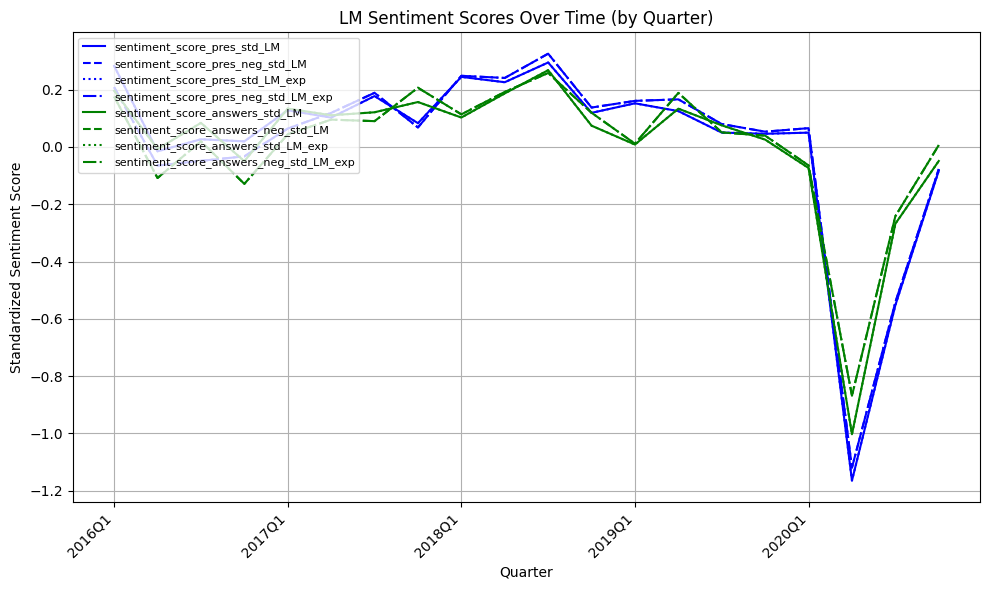

In [17]:
# Plot 1: LM Scores
plt.figure(figsize=(10, 6))
mean_scores_df = scores_df.groupby('quarter')[lm_score_columns].mean()
quarters = mean_scores_df.index.astype(str)

# Presentations (blue) and Answers (green) with different line styles
plt.plot(quarters, mean_scores_df['sentiment_score_pres_std_LM'], label='sentiment_score_pres_std_LM', color='blue', linestyle='-')
plt.plot(quarters, mean_scores_df['sentiment_score_pres_neg_std_LM'], label='sentiment_score_pres_neg_std_LM', color='blue', linestyle='--')
plt.plot(quarters, mean_scores_df['sentiment_score_pres_std_LM_exp'], label='sentiment_score_pres_std_LM_exp', color='blue', linestyle=':')
plt.plot(quarters, mean_scores_df['sentiment_score_pres_neg_std_LM_exp'], label='sentiment_score_pres_neg_std_LM_exp', color='blue', linestyle='-.')
plt.plot(quarters, mean_scores_df['sentiment_score_answers_std_LM'], label='sentiment_score_answers_std_LM', color='green', linestyle='-')
plt.plot(quarters, mean_scores_df['sentiment_score_answers_neg_std_LM'], label='sentiment_score_answers_neg_std_LM', color='green', linestyle='--')
plt.plot(quarters, mean_scores_df['sentiment_score_answers_std_LM_exp'], label='sentiment_score_answers_std_LM_exp', color='green', linestyle=':')
plt.plot(quarters, mean_scores_df['sentiment_score_answers_neg_std_LM_exp'], label='sentiment_score_answers_neg_std_LM_exp', color='green', linestyle='-.')

plt.title('LM Sentiment Scores Over Time (by Quarter)')
plt.xlabel('Quarter')
plt.ylabel('Standardized Sentiment Score')
plt.legend(loc='upper left', fontsize=8, framealpha=0.8)
plt.grid(True)
plt.xticks(ticks=range(0, len(quarters), 4), labels=quarters[::4], rotation=45, ha='right')
plt.tight_layout()
plt.show()


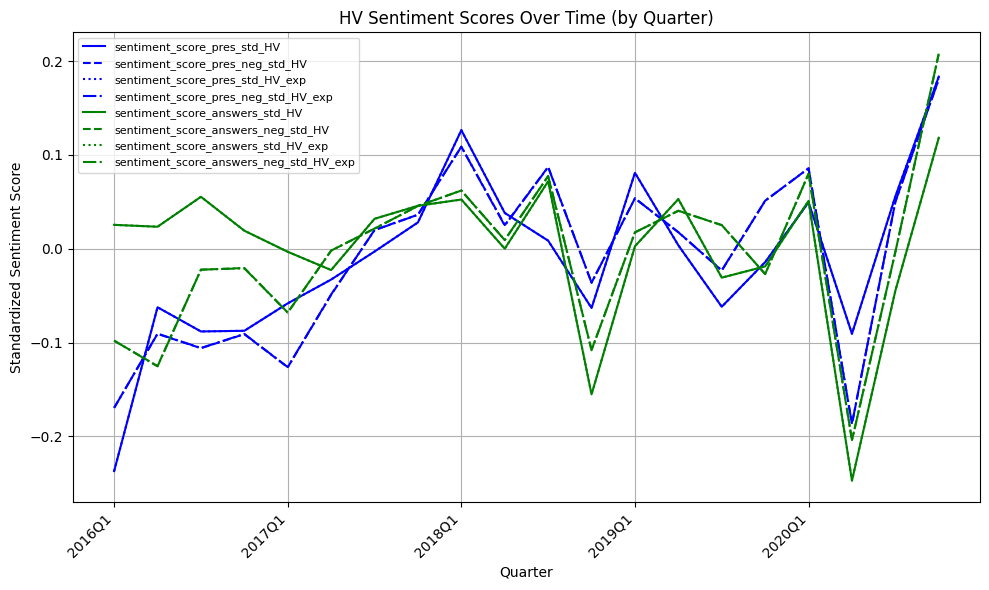

In [18]:
# Plot 2: HV Scores
plt.figure(figsize=(10, 6))
mean_scores_df = scores_df.groupby('quarter')[hv_score_columns].mean()
quarters = mean_scores_df.index.astype(str)

# Presentations (blue) and Answers (green) with different line styles
plt.plot(quarters, mean_scores_df['sentiment_score_pres_std_HV'], label='sentiment_score_pres_std_HV', color='blue', linestyle='-')
plt.plot(quarters, mean_scores_df['sentiment_score_pres_neg_std_HV'], label='sentiment_score_pres_neg_std_HV', color='blue', linestyle='--')
plt.plot(quarters, mean_scores_df['sentiment_score_pres_std_HV_exp'], label='sentiment_score_pres_std_HV_exp', color='blue', linestyle=':')
plt.plot(quarters, mean_scores_df['sentiment_score_pres_neg_std_HV_exp'], label='sentiment_score_pres_neg_std_HV_exp', color='blue', linestyle='-.')
plt.plot(quarters, mean_scores_df['sentiment_score_answers_std_HV'], label='sentiment_score_answers_std_HV', color='green', linestyle='-')
plt.plot(quarters, mean_scores_df['sentiment_score_answers_neg_std_HV'], label='sentiment_score_answers_neg_std_HV', color='green', linestyle='--')
plt.plot(quarters, mean_scores_df['sentiment_score_answers_std_HV_exp'], label='sentiment_score_answers_std_HV_exp', color='green', linestyle=':')
plt.plot(quarters, mean_scores_df['sentiment_score_answers_neg_std_HV_exp'], label='sentiment_score_answers_neg_std_HV_exp', color='green', linestyle='-.')

plt.title('HV Sentiment Scores Over Time (by Quarter)')
plt.xlabel('Quarter')
plt.ylabel('Standardized Sentiment Score')
plt.legend(loc='upper left', fontsize=8, framealpha=0.8)
plt.grid(True)
plt.xticks(ticks=range(0, len(quarters), 4), labels=quarters[::4], rotation=45, ha='right')
plt.tight_layout()
plt.show()


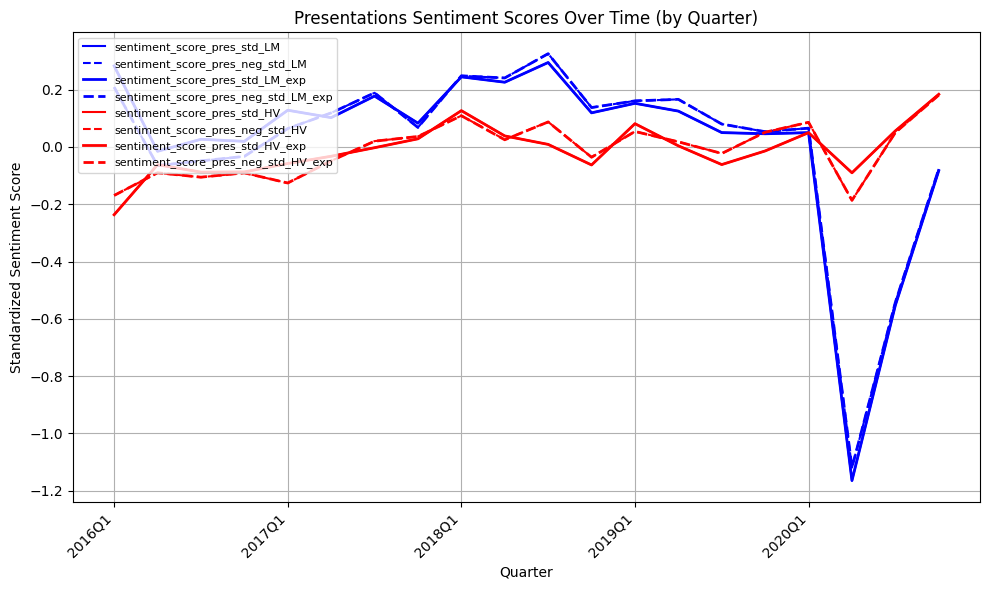

In [19]:
# Plot 3: Presentations Scores
plt.figure(figsize=(10, 6))
mean_scores_df = scores_df.groupby('quarter')[pres_score_columns].mean()
quarters = mean_scores_df.index.astype(str)

# LM lines in blue, HV lines in red, with different line styles
plt.plot(quarters, mean_scores_df['sentiment_score_pres_std_LM'], label='sentiment_score_pres_std_LM', color='blue', linestyle='-')
plt.plot(quarters, mean_scores_df['sentiment_score_pres_neg_std_LM'], label='sentiment_score_pres_neg_std_LM', color='blue', linestyle='--')
plt.plot(quarters, mean_scores_df['sentiment_score_pres_std_LM_exp'], label='sentiment_score_pres_std_LM_exp', color='blue', linestyle='-', linewidth=2)
plt.plot(quarters, mean_scores_df['sentiment_score_pres_neg_std_LM_exp'], label='sentiment_score_pres_neg_std_LM_exp', color='blue', linestyle='--', linewidth=2)
plt.plot(quarters, mean_scores_df['sentiment_score_pres_std_HV'], label='sentiment_score_pres_std_HV', color='red', linestyle='-')
plt.plot(quarters, mean_scores_df['sentiment_score_pres_neg_std_HV'], label='sentiment_score_pres_neg_std_HV', color='red', linestyle='--')
plt.plot(quarters, mean_scores_df['sentiment_score_pres_std_HV_exp'], label='sentiment_score_pres_std_HV_exp', color='red', linestyle='-', linewidth=2)
plt.plot(quarters, mean_scores_df['sentiment_score_pres_neg_std_HV_exp'], label='sentiment_score_pres_neg_std_HV_exp', color='red', linestyle='--', linewidth=2)

plt.title('Presentations Sentiment Scores Over Time (by Quarter)')
plt.xlabel('Quarter')
plt.ylabel('Standardized Sentiment Score')
plt.legend(loc='upper left', fontsize=8, framealpha=0.8)
plt.grid(True)
plt.xticks(ticks=range(0, len(quarters), 4), labels=quarters[::4], rotation=45, ha='right')
plt.tight_layout()
plt.show()

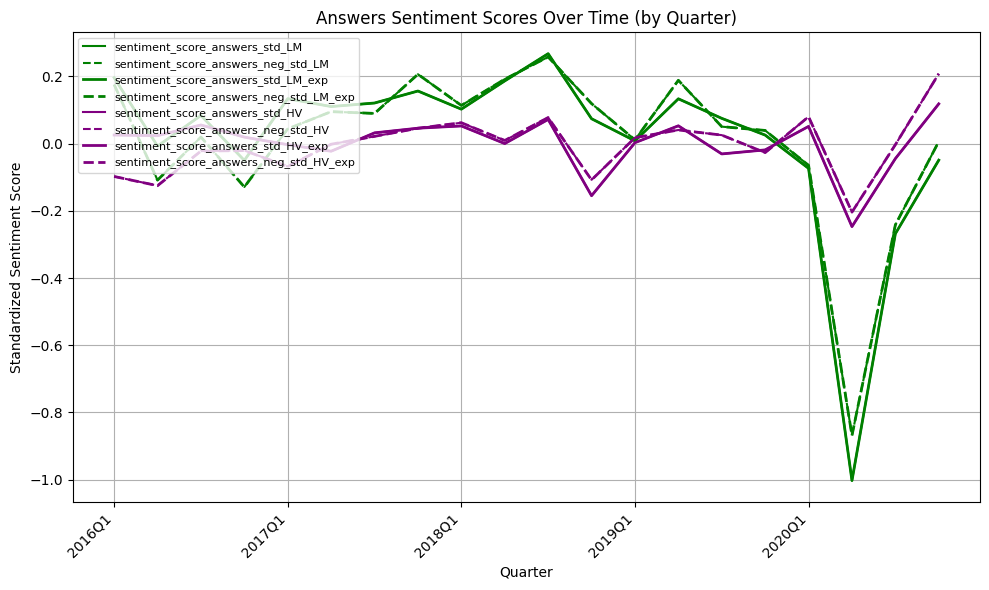

In [20]:
# Plot 4: Answers Scores
plt.figure(figsize=(10, 6))
mean_scores_df = scores_df.groupby('quarter')[answers_score_columns].mean()
quarters = mean_scores_df.index.astype(str)

# LM lines in green, HV lines in purple, with different line styles
plt.plot(quarters, mean_scores_df['sentiment_score_answers_std_LM'], label='sentiment_score_answers_std_LM', color='green', linestyle='-')
plt.plot(quarters, mean_scores_df['sentiment_score_answers_neg_std_LM'], label='sentiment_score_answers_neg_std_LM', color='green', linestyle='--')
plt.plot(quarters, mean_scores_df['sentiment_score_answers_std_LM_exp'], label='sentiment_score_answers_std_LM_exp', color='green', linestyle='-', linewidth=2)
plt.plot(quarters, mean_scores_df['sentiment_score_answers_neg_std_LM_exp'], label='sentiment_score_answers_neg_std_LM_exp', color='green', linestyle='--', linewidth=2)
plt.plot(quarters, mean_scores_df['sentiment_score_answers_std_HV'], label='sentiment_score_answers_std_HV', color='purple', linestyle='-')
plt.plot(quarters, mean_scores_df['sentiment_score_answers_neg_std_HV'], label='sentiment_score_answers_neg_std_HV', color='purple', linestyle='--')
plt.plot(quarters, mean_scores_df['sentiment_score_answers_std_HV_exp'], label='sentiment_score_answers_std_HV_exp', color='purple', linestyle='-', linewidth=2)
plt.plot(quarters, mean_scores_df['sentiment_score_answers_neg_std_HV_exp'], label='sentiment_score_answers_neg_std_HV_exp', color='purple', linestyle='--', linewidth=2)

plt.title('Answers Sentiment Scores Over Time (by Quarter)')
plt.xlabel('Quarter')
plt.ylabel('Standardized Sentiment Score')
plt.legend(loc='upper left', fontsize=8, framealpha=0.8)
plt.grid(True)
plt.xticks(ticks=range(0, len(quarters), 4), labels=quarters[::4], rotation=45, ha='right')
plt.tight_layout()
plt.show()

Plot the LLM scores over time

In [21]:
# extrac the LLM scores
llm_score_columns = [
    'sentiment_score_pres_finbert_std', 'sentiment_score_pres_distilbert_std',
    'sentiment_score_pres_chatgpt_std',
    'sentiment_score_answers_finbert_std', 'sentiment_score_answers_distilbert_std',
    'sentiment_score_answers_chatgpt_std'
]

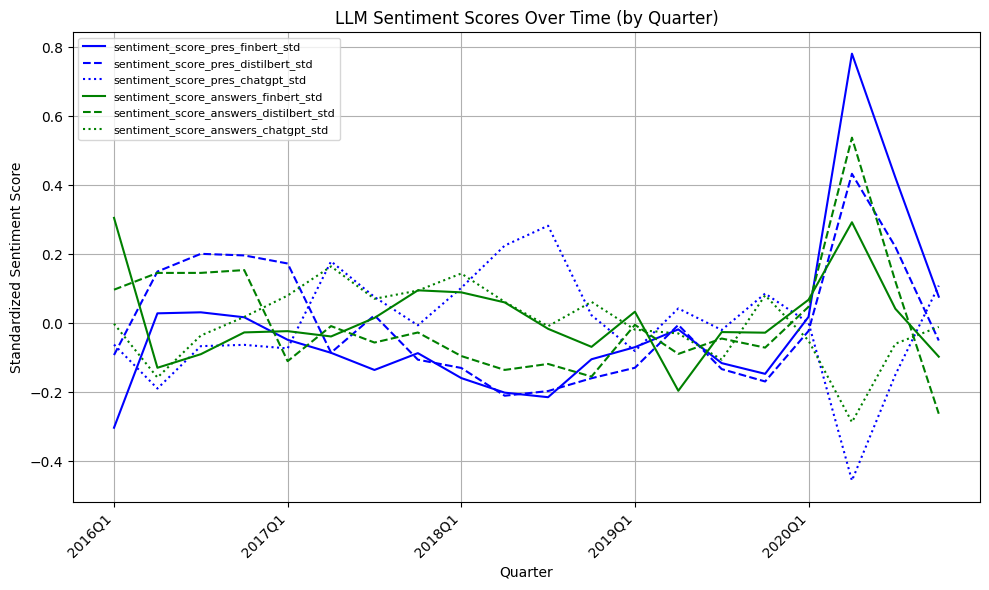

In [22]:
# plot the LLMs mean score overtime
plt.figure(figsize=(10, 6))
mean_scores_df = scores_df.groupby('quarter')[llm_score_columns].mean()
quarters = mean_scores_df.index.astype(str)

# Plot presentation-related lines in blue
plt.plot(quarters, mean_scores_df['sentiment_score_pres_finbert_std'], label='sentiment_score_pres_finbert_std', color='blue', linestyle='-')
plt.plot(quarters, mean_scores_df['sentiment_score_pres_distilbert_std'], label='sentiment_score_pres_distilbert_std', color='blue', linestyle='--')
plt.plot(quarters, mean_scores_df['sentiment_score_pres_chatgpt_std'], label='sentiment_score_pres_chatgpt_std', color='blue', linestyle=':')

# Plot answer-related lines in green
plt.plot(quarters, mean_scores_df['sentiment_score_answers_finbert_std'], label='sentiment_score_answers_finbert_std', color='green', linestyle='-')
plt.plot(quarters, mean_scores_df['sentiment_score_answers_distilbert_std'], label='sentiment_score_answers_distilbert_std', color='green', linestyle='--')
plt.plot(quarters, mean_scores_df['sentiment_score_answers_chatgpt_std'], label='sentiment_score_answers_chatgpt_std', color='green', linestyle=':')

plt.title('LLM Sentiment Scores Over Time (by Quarter)')
plt.xlabel('Quarter')
plt.ylabel('Standardized Sentiment Score')
plt.legend(loc='upper left', fontsize=8, framealpha=0.8)
plt.grid(True)
plt.xticks(ticks=range(0, len(quarters), 4), labels=quarters[::4], rotation=45, ha='right')
plt.tight_layout()
plt.show()

Plot correlation heatmap of BoW scores

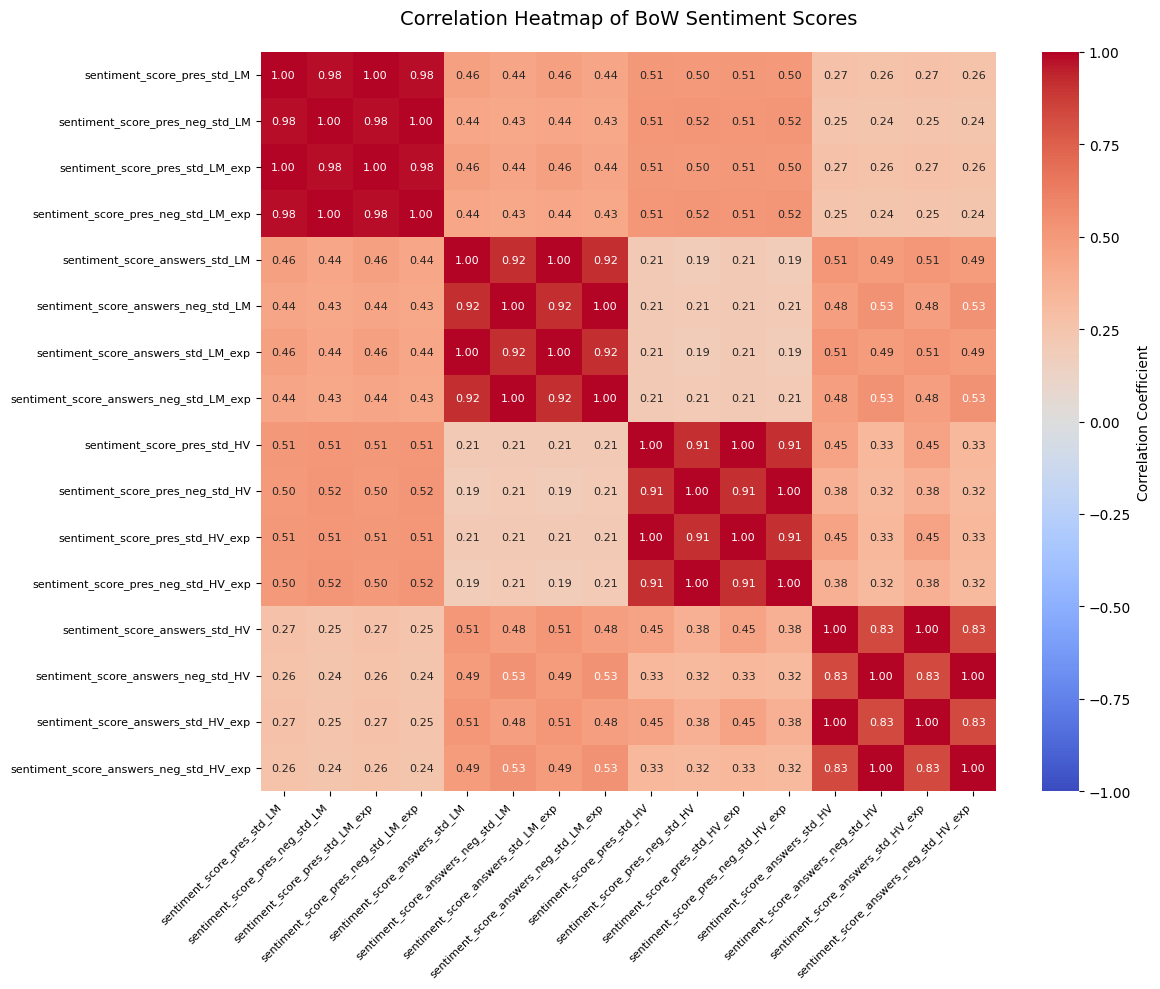

In [23]:
# Define the BoW score columns (LM and HV combined)
bow_score_columns = lm_score_columns + hv_score_columns

# Heatmap 1: Correlation Heatmap of BoW Sentiment Scores
plt.figure(figsize=(12, 10))
bow_corr = scores_df[bow_score_columns].corr()
sns.heatmap(bow_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0,
            fmt='.2f', annot_kws={'size': 8}, cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Correlation Heatmap of BoW Sentiment Scores', fontsize=14, pad=20)
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.show()

Plot correlation heatmap of LLM Sentiment Scores

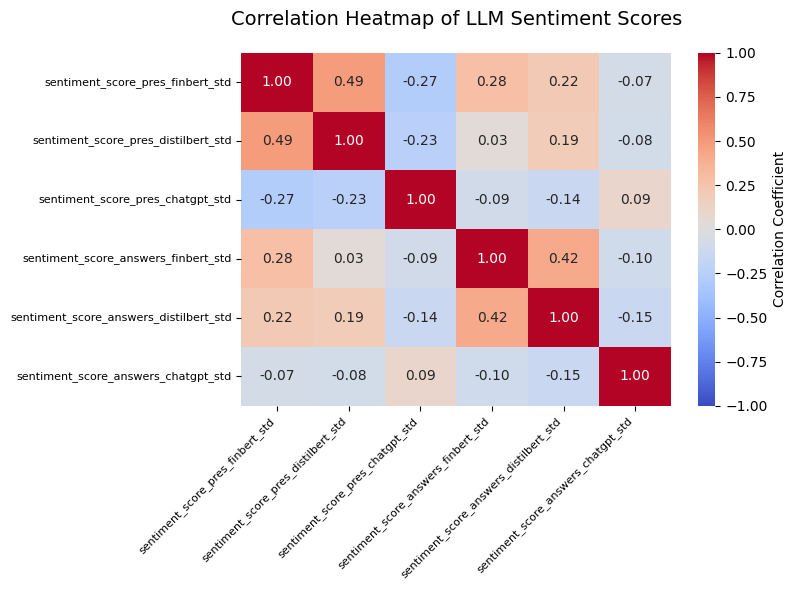

In [24]:
# Heatmap 2: Correlation Heatmap of LLM Sentiment Scores
plt.figure(figsize=(8, 6))
llm_corr = scores_df[llm_score_columns].corr()
sns.heatmap(llm_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0,
            fmt='.2f', annot_kws={'size': 10}, cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Correlation Heatmap of LLM Sentiment Scores', fontsize=14, pad=20)
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.show()

PLot combined heatmap of BoW and LLMs

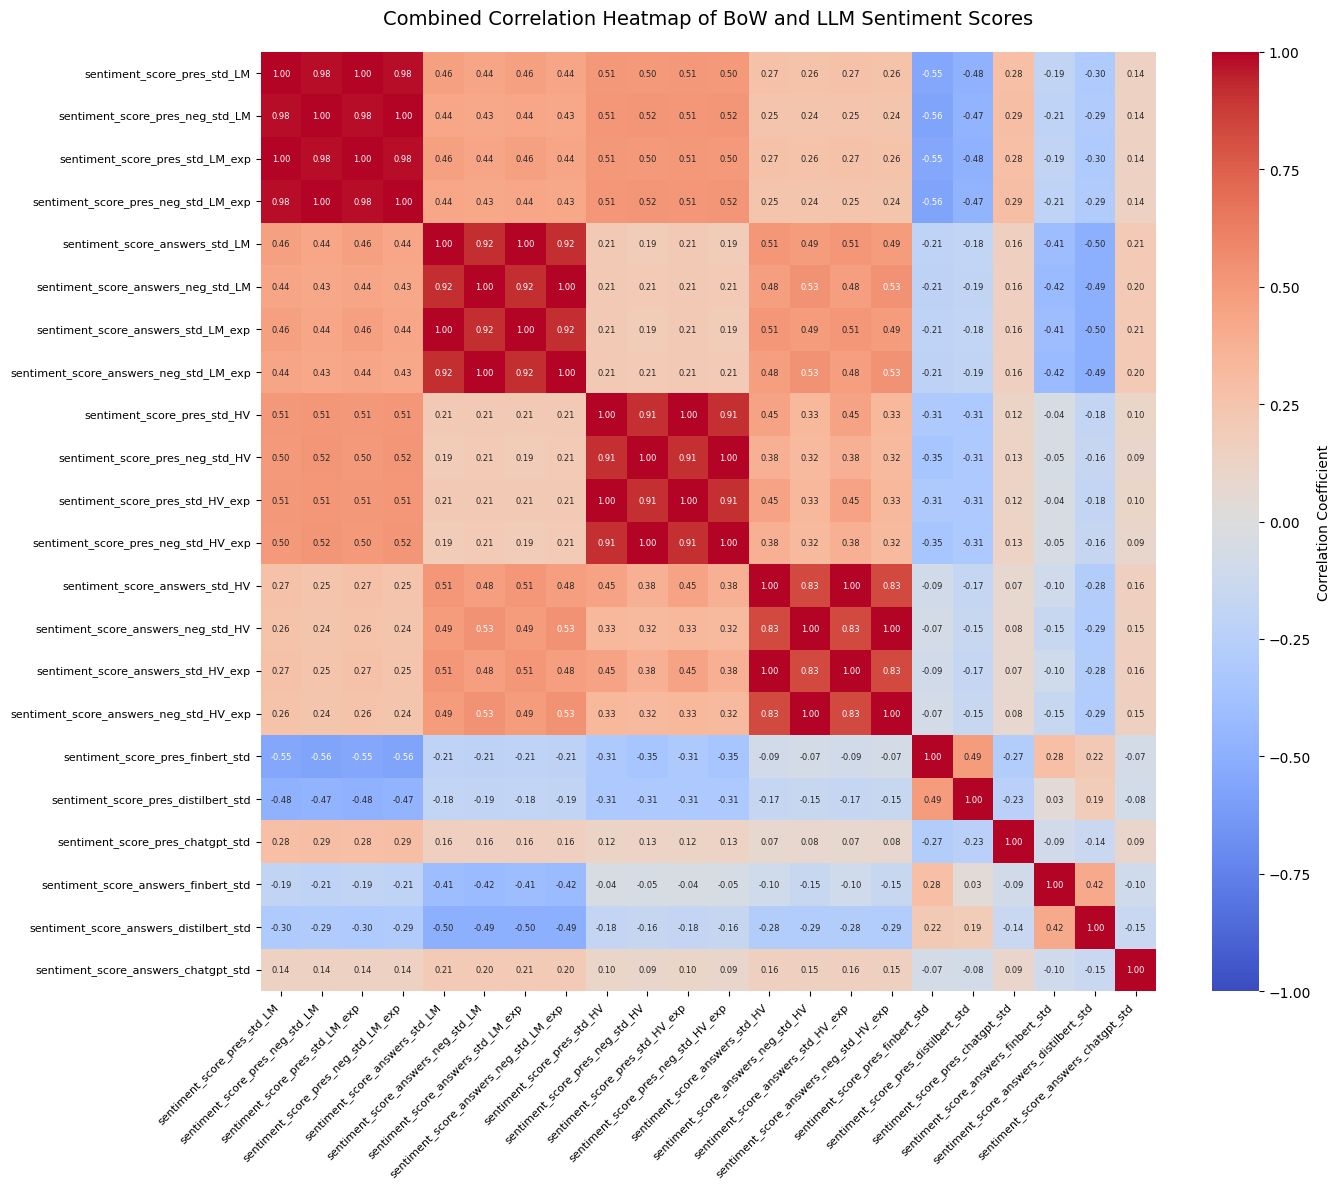

In [25]:
# Heatmap 3: Combined Correlation Heatmap of BoW and LLM Sentiment Scores
all_score_columns = bow_score_columns + llm_score_columns
plt.figure(figsize=(14, 12))
all_corr = scores_df[all_score_columns].corr()
sns.heatmap(all_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0,
            fmt='.2f', annot_kws={'size': 6}, cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Combined Correlation Heatmap of BoW and LLM Sentiment Scores', fontsize=14, pad=20)
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.show()

---
# Long-short portfolios
---

* Go long the 10% higest sentiment scores
* Go short the 10% lowest sentiment scores

In [26]:
# combine all sentiment columns
all_sentiment_cols_std = lm_score_columns + hv_score_columns + llm_score_columns
all_sentiment_cols_std

['sentiment_score_pres_std_LM',
 'sentiment_score_pres_neg_std_LM',
 'sentiment_score_pres_std_LM_exp',
 'sentiment_score_pres_neg_std_LM_exp',
 'sentiment_score_answers_std_LM',
 'sentiment_score_answers_neg_std_LM',
 'sentiment_score_answers_std_LM_exp',
 'sentiment_score_answers_neg_std_LM_exp',
 'sentiment_score_pres_std_HV',
 'sentiment_score_pres_neg_std_HV',
 'sentiment_score_pres_std_HV_exp',
 'sentiment_score_pres_neg_std_HV_exp',
 'sentiment_score_answers_std_HV',
 'sentiment_score_answers_neg_std_HV',
 'sentiment_score_answers_std_HV_exp',
 'sentiment_score_answers_neg_std_HV_exp',
 'sentiment_score_pres_finbert_std',
 'sentiment_score_pres_distilbert_std',
 'sentiment_score_pres_chatgpt_std',
 'sentiment_score_answers_finbert_std',
 'sentiment_score_answers_distilbert_std',
 'sentiment_score_answers_chatgpt_std']

In [27]:
# Non-standardized columns
lm_non_std_cols = [
    'sentiment_score_pres_LM', 'sentiment_score_pres_neg_LM',
    'sentiment_score_pres_LM_exp', 'sentiment_score_pres_neg_LM_exp',
    'sentiment_score_answers_LM', 'sentiment_score_answers_neg_LM',
    'sentiment_score_answers_LM_exp', 'sentiment_score_answers_neg_LM_exp'
]

hv_non_std_cols = [
    'sentiment_score_pres_HV', 'sentiment_score_pres_neg_HV',
    'sentiment_score_pres_HV_exp', 'sentiment_score_pres_neg_HV_exp',
    'sentiment_score_answers_HV', 'sentiment_score_answers_neg_HV',
    'sentiment_score_answers_HV_exp', 'sentiment_score_answers_neg_HV_exp'
]

llm_non_std_cols = [
    'sentiment_score_pres_finbert', 'sentiment_score_pres_distilbert', 'sentiment_score_pres_chatgpt',
    'sentiment_score_answers_finbert', 'sentiment_score_answers_distilbert', 'sentiment_score_answers_chatgpt'
]

all_non_std_cols = lm_non_std_cols + hv_non_std_cols + llm_non_std_cols

In [28]:
# Start with metadata columns from ec_pres_bow
meta_cols = ['file_name', 'GVKEY', 'CAR-11-Carhart', 'atq', 'NUMEST', 'SurpDec', 'date_rdq']
scores_non_std_df = ec_pres_bow[meta_cols].drop_duplicates(subset='file_name')

# Merge non-standardized LM and HV scores from ec_pres_bow and answers_bow
scores_non_std_df = scores_non_std_df.merge(
    ec_pres_bow[['file_name'] + [col for col in lm_non_std_cols + hv_non_std_cols if 'pres' in col]],
    on='file_name',
    how='left'
)
scores_non_std_df = scores_non_std_df.merge(
    answers_bow[['file_name'] + [col for col in lm_non_std_cols + hv_non_std_cols if 'answers' in col]],
    on='file_name',
    how='left'
)

# Merge non-standardized LLM scores from ec_pres_llm and answers_llm
scores_non_std_df = scores_non_std_df.merge(
    ec_pres_llm[['file_name'] + [col for col in llm_non_std_cols if 'pres' in col]],
    on='file_name',
    how='left'
)
scores_non_std_df = scores_non_std_df.merge(
    answers_llm[['file_name'] + [col for col in llm_non_std_cols if 'answers' in col]],
    on='file_name',
    how='left'
)

# Convert date_rdq to quarter and fill missing CAR-11-Carhart
scores_non_std_df['date_rdq'] = pd.to_datetime(scores_non_std_df['date_rdq'])
scores_non_std_df['quarter'] = scores_non_std_df['date_rdq'].dt.to_period('Q')
scores_non_std_df['CAR-11-Carhart'] = scores_non_std_df['CAR-11-Carhart'].fillna(0)

# Quick check
print("scores_non_std_df shape:", scores_non_std_df.shape)

scores_non_std_df shape: (2877, 30)


<ipython-input-28-cd0bf7d96c46>:31: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  scores_non_std_df['quarter'] = scores_non_std_df['date_rdq'].dt.to_period('Q')


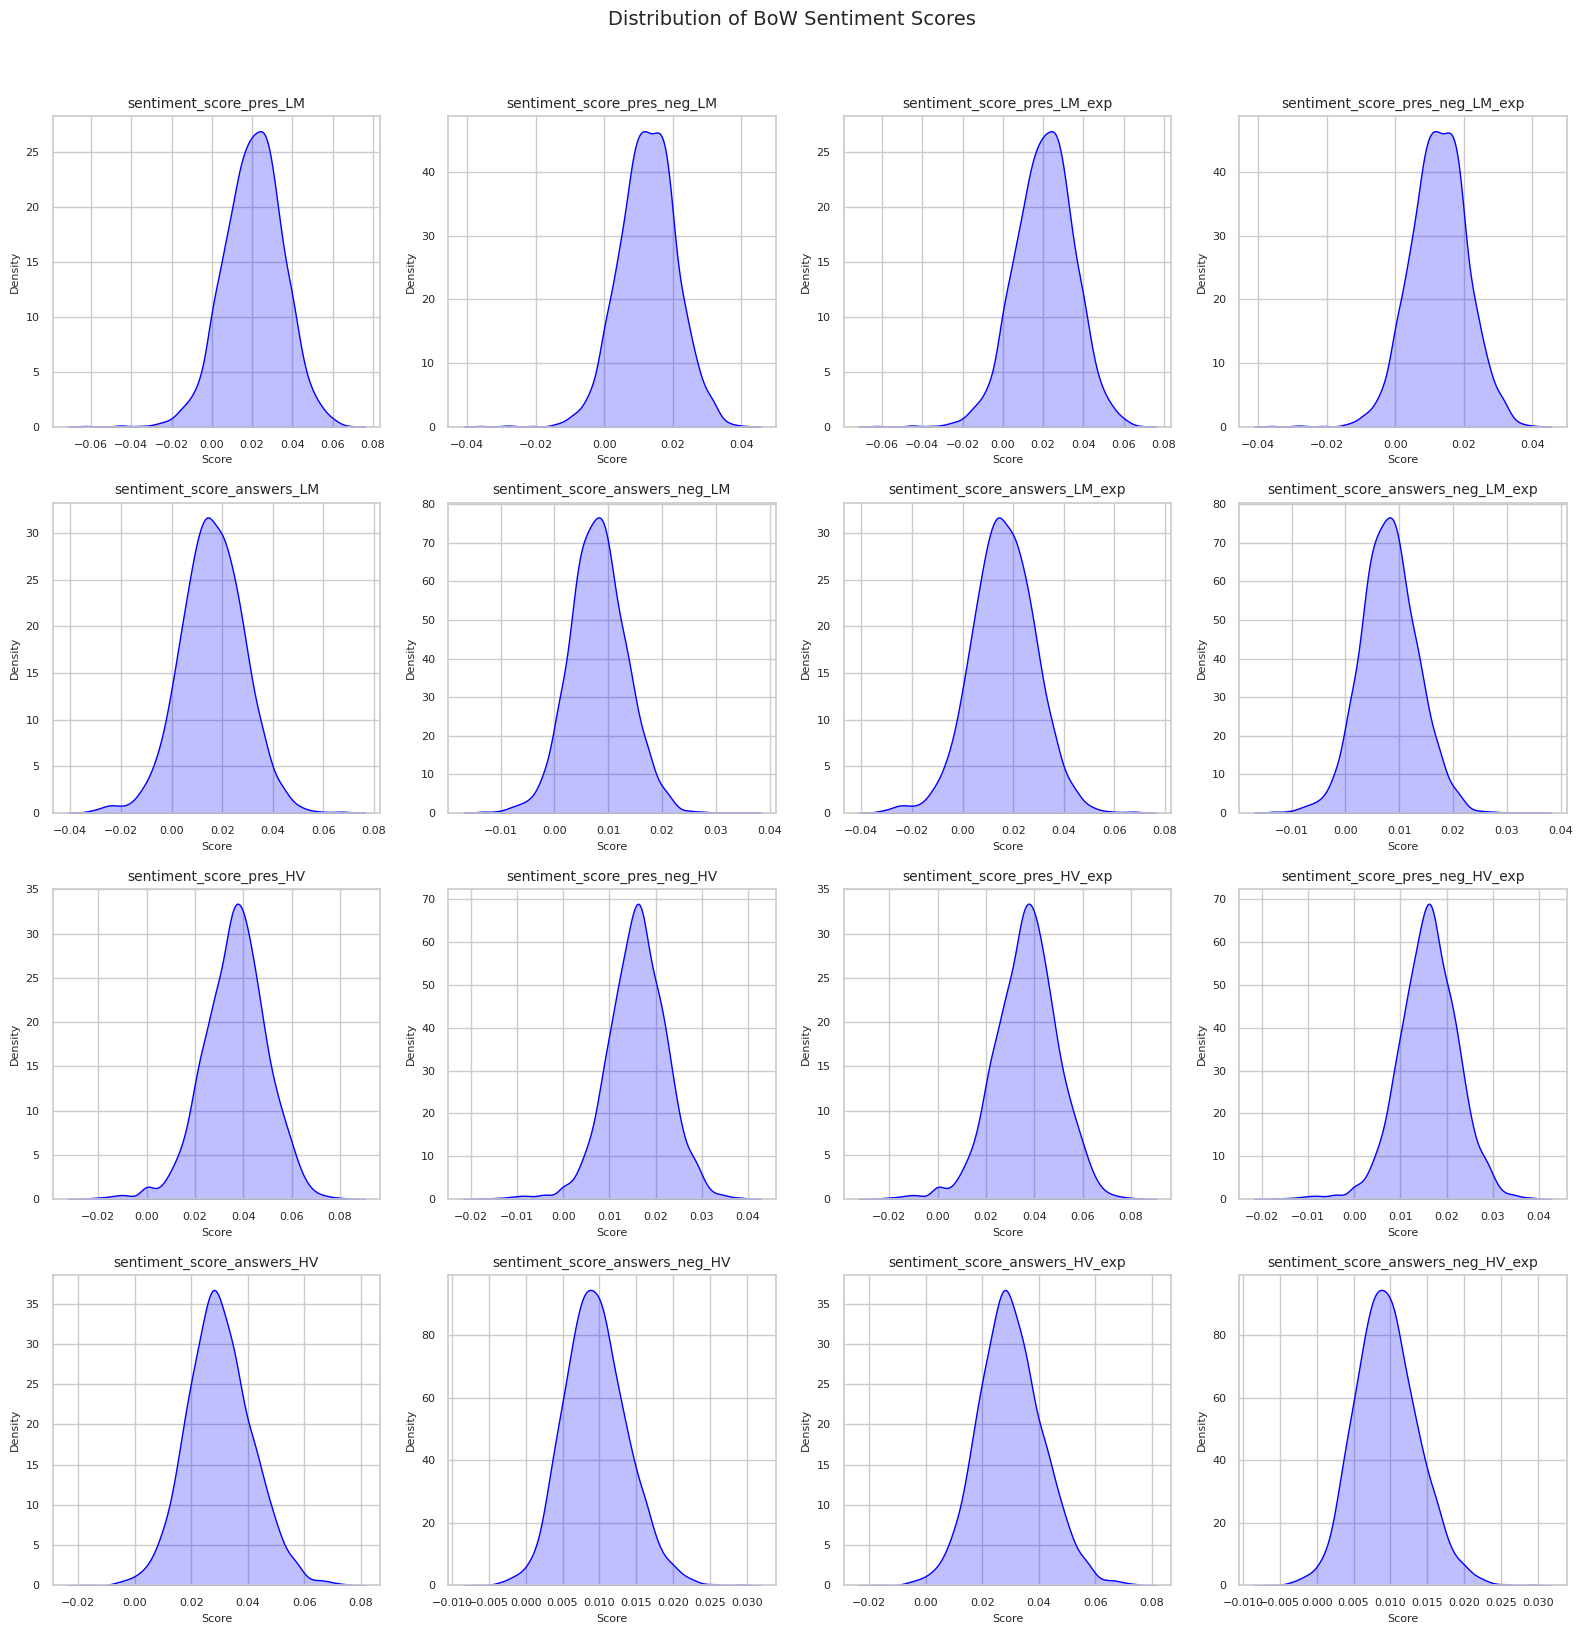

In [61]:
# plot the distribution of scores for BoW

# Set up the plotting style
sns.set(style="whitegrid")

# --- Plot 1: BoW Sentiment Score Distributions ---
# Combine LM and HV columns for BoW
bow_cols = lm_non_std_cols + hv_non_std_cols
num_bow_cols = len(bow_cols)  # 16 columns

# Create a grid of subplots for BoW (4 rows x 4 columns = 16 subplots)
nrows_bow = 4
ncols_bow = 4
fig_bow, axes_bow = plt.subplots(nrows=nrows_bow, ncols=ncols_bow, figsize=(16, 16), sharex=False, sharey=False)
axes_bow = axes_bow.flatten()  # Flatten for easier indexing

# Plot the distribution for each BoW column
for i, col in enumerate(bow_cols):
    data = scores_non_std_df[col].dropna()
    sns.kdeplot(data=data, ax=axes_bow[i], color='blue', fill=True)
    axes_bow[i].set_title(col, fontsize=10)
    axes_bow[i].set_xlabel('Score', fontsize=8)
    axes_bow[i].set_ylabel('Density', fontsize=8)
    axes_bow[i].tick_params(axis='both', labelsize=8)

# Remove empty subplots (if any)
for i in range(num_bow_cols, nrows_bow * ncols_bow):
    fig_bow.delaxes(axes_bow[i])

# Adjust layout and save the plot
plt.suptitle('Distribution of BoW Sentiment Scores', fontsize=14, y=1.02)
plt.tight_layout()
#plt.savefig('bow_sentiment_distributions.png', dpi=300, bbox_inches='tight')
plt.show()
#plt.close(fig_bow)

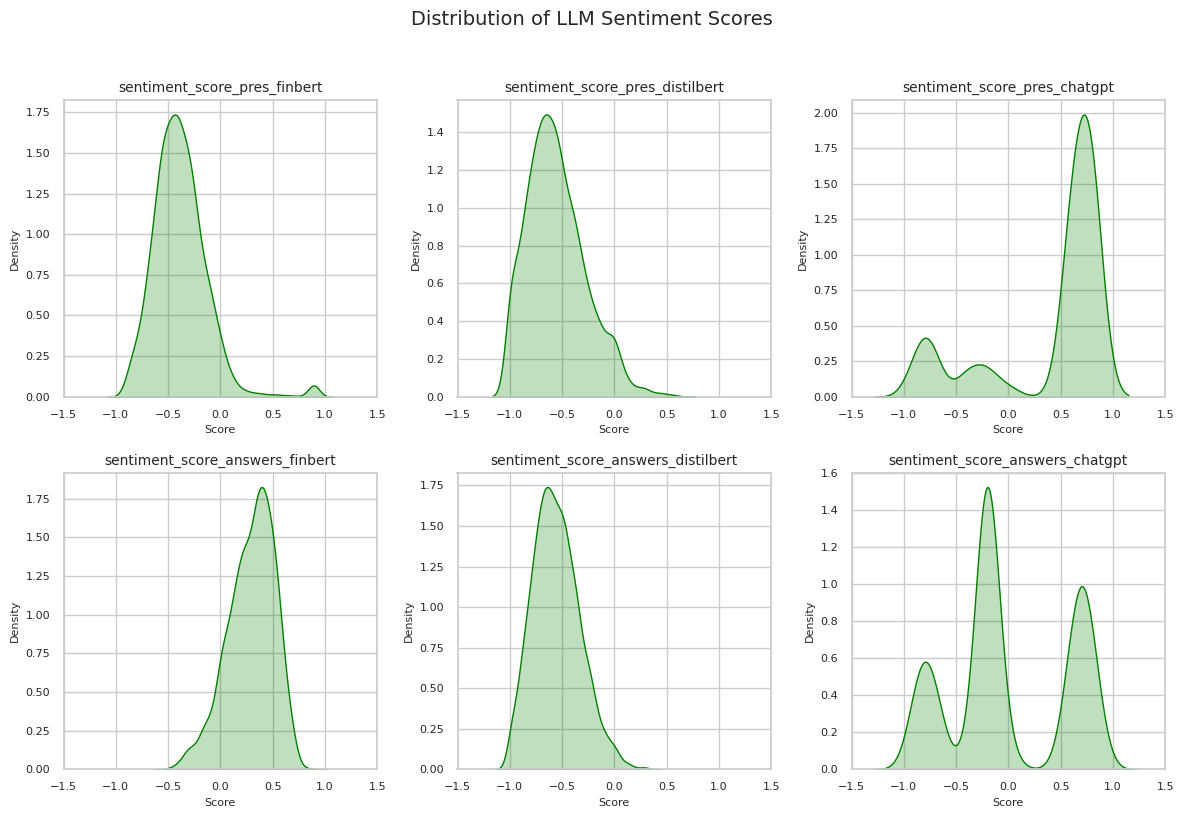

In [64]:
# --- Plot 2: LLM Sentiment Score Distributions ---
num_llm_cols = len(llm_non_std_cols)  # 6 columns

# Create a grid of subplots for LLM (2 rows x 3 columns = 6 subplots)
nrows_llm = 2
ncols_llm = 3
fig_llm, axes_llm = plt.subplots(nrows=nrows_llm, ncols=ncols_llm, figsize=(12, 8), sharex=False, sharey=False)
axes_llm = axes_llm.flatten()  # Flatten for easier indexing

# Plot the distribution for each LLM column
for i, col in enumerate(llm_non_std_cols):
    data = scores_non_std_df[col].dropna()
    sns.kdeplot(data=data, ax=axes_llm[i], color='green', fill=True)
    axes_llm[i].set_title(col, fontsize=10)
    axes_llm[i].set_xlabel('Score', fontsize=8)
    axes_llm[i].set_ylabel('Density', fontsize=8)
    axes_llm[i].set_xlim(-1.5, 1.5)  # Adjust x-axis limits if needed
    axes_llm[i].tick_params(axis='both', labelsize=8)

# Remove empty subplots (if any)
for i in range(num_llm_cols, nrows_llm * ncols_llm):
    fig_llm.delaxes(axes_llm[i])

# Adjust layout and save the plot
plt.suptitle('Distribution of LLM Sentiment Scores', fontsize=14, y=1.02)
plt.tight_layout()
#plt.savefig('llm_sentiment_distributions.png', dpi=300, bbox_inches='tight')
plt.show()
#plt.close(fig_llm)

In [30]:
# Define a simple L–S calculation function using terciles
def calc_ls_return_for_date(group, sentiment_col, return_col, n=3, min_obs=20):
    """
    Calculate long-short return for a given group (one quarter).
      - Expects at least min_obs rows after dropping NaNs.
      - Forms n=3 bins (terciles) of sentiment,
        returns mean(top tercile) - mean(bottom tercile).
      - Returns np.nan if we can't form top and bottom.
    """
    # Drop rows missing sentiment or return
    sub = group.dropna(subset=[sentiment_col, return_col])
    if len(sub) < min_obs:
        return np.nan

    # Attempt to split into terciles
    try:
        sub['tercile'] = pd.qcut(sub[sentiment_col], q=n, labels=False, duplicates='drop')
    except ValueError:
        # If there's not enough variation to split properly
        return np.nan

    # We need both top tercile (n-1) and bottom tercile (0) to exist
    if (n-1 not in sub['tercile'].values) or (0 not in sub['tercile'].values):
        return np.nan

    top_ret = sub.loc[sub['tercile'] == (n-1), return_col].mean()
    bot_ret = sub.loc[sub['tercile'] == 0,          return_col].mean()
    return top_ret - bot_ret

In [31]:
from scipy import stats
# calcualte LS-portfolios
return_col = 'CAR-11-Carhart'
date_col   = 'quarter'
min_obs    = 20  # at least 20 observations per quarter
n_bins     = 3   # terciles

# Loop over each sentiment column, compute L–S per quarter, then average
results_list = []

for sentiment_col in all_non_std_cols:
    # Apply our function for each quarter, dropping NaNs from the L–S results
    ls_series = (
        scores_non_std_df
        .groupby(date_col, group_keys=False)
        .apply(lambda g: calc_ls_return_for_date(
            group=g,
            sentiment_col=sentiment_col,
            return_col=return_col,
            n=n_bins,
            min_obs=min_obs
        ))
        .dropna()
    )

    # If no valid quarters, fill with NaN
    if len(ls_series) == 0:
        avg_ls = np.nan
        t_stat = np.nan
        p_val = np.nan
        n_quarters = 0
    else:
        # Compute average L–S return
        avg_ls = ls_series.mean()
        # T-test vs 0
        t_stat, p_val = stats.ttest_1samp(ls_series, 0, nan_policy='omit')
        n_quarters = len(ls_series)

    results_list.append({
        "sentiment_col": sentiment_col,
        "avg_LS_return": avg_ls,
        "t_stat": t_stat,
        "p_val": p_val,
        "n_quarters": n_quarters
    })

<ipython-input-31-ba641249b5c5>:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: calc_ls_return_for_date(
<ipython-input-31-ba641249b5c5>:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: calc_ls_return_for_date(
<ipython-input-31-ba641249b5c5>:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future vers

In [32]:
# summarize the the results
ls_results_df = pd.DataFrame(results_list)
ls_results_df = ls_results_df.sort_values("avg_LS_return", ascending=False)
ls_results_df

,sentiment_col,avg_LS_return,t_stat,p_val,n_quarters
3,sentiment_score_pres_neg_LM_exp,0.016363,6.167719,0.000008,19
1,sentiment_score_pres_neg_LM,0.016363,6.167719,0.000008,19
0,sentiment_score_pres_LM,0.016036,5.769736,0.000018,19
2,sentiment_score_pres_LM_exp,0.016036,5.769736,0.000018,19
7,sentiment_score_answers_neg_LM_exp,0.014693,5.532219,0.000030,19
5,sentiment_score_answers_neg_LM,0.014693,5.532219,0.000030,19
21,sentiment_score_answers_chatgpt,0.013626,5.004928,0.000130,17
6,sentiment_score_answers_LM_exp,0.012882,5.689498,0.000021,19
4,sentiment_score_answers_LM,0.012882,5.689498,0.000021,19
18,sentiment_score_pres_chatgpt,0.012184,4.465062,0.000299,19


**Comment on LS portfolios**
* I orginally tried constructing portfolios based on deciles, which created bad resualts for chatgpt due to the extreme distribution. Moving on i tried treciles, which again created to few observations to performe a statiscally reliable result.

---
# Fama-MacBeth regressions
---

In [33]:
# Start with metadata from ec_pres_bow
meta_df = ec_pres_bow[meta_cols].drop_duplicates(subset='file_name')

In [34]:
#Merge that metadata into scores_df
scores_df = scores_df.merge(meta_df, on='file_name', how='left')

In [35]:
# take a look
scores_df

,file_name,co_conm,date_rdq_x,sentiment_score_pres_std_LM,sentiment_score_pres_neg_std_LM,sentiment_score_pres_std_HV,sentiment_score_pres_neg_std_HV,sentiment_score_pres_std_LM_exp,sentiment_score_pres_neg_std_LM_exp,sentiment_score_pres_std_HV_exp,...,sentiment_score_answers_finbert_std,sentiment_score_answers_distilbert_std,sentiment_score_answers_chatgpt_std,quarter,GVKEY,CAR-11-Carhart,atq,NUMEST,SurpDec,date_rdq_y
0,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...,PRUDENTIAL FINANCIAL INC,2016-05-05 15:00:00+00:00,-1.332424,-1.195693,-0.055023,-0.031424,-1.332424,-1.195693,-0.055023,...,1.111101,0.088621,-0.345943,2016Q2,143356.0,-0.015353,772995.000,18.0,-3.0,2016-05-05 15:00:00+00:00
1,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...,PRUDENTIAL FINANCIAL INC,2016-08-04 15:00:00+00:00,-1.156602,-1.014589,-0.192013,0.045910,-1.156602,-1.014589,-0.192013,...,1.033050,0.231937,-0.345943,2016Q3,143356.0,-0.000416,796490.000,17.0,-4.0,2016-08-04 15:00:00+00:00
2,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...,PRUDENTIAL FINANCIAL INC,2016-11-03 13:00:00+00:00,-0.118174,0.264754,0.623192,0.983163,-0.118174,0.264754,0.623192,...,0.583545,0.359067,-0.345943,2016Q4,143356.0,0.031476,819865.000,17.0,3.0,2016-11-03 13:00:00+00:00
3,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...,LILLY (ELI) & CO,2016-04-26 13:00:00+00:00,-1.262029,-1.274367,-1.013272,-0.960079,-1.262029,-1.274367,-1.013272,...,0.586830,1.483977,-0.345943,2016Q2,6730.0,-0.004689,34691.800,18.0,-1.0,2016-04-26 13:00:00+00:00
4,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...,LILLY (ELI) & CO,2016-07-26 13:00:00+00:00,-0.529606,-0.658582,-0.998017,-1.002363,-0.529606,-0.658582,-0.998017,...,0.756661,2.553813,0.010381,2016Q3,6730.0,0.027560,36475.300,18.0,1.0,2016-07-26 13:00:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2872,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2020...,NIKE INC -CL B,2020-12-18 22:00:00+00:00,1.012829,0.847231,-0.165210,-0.103148,1.012829,0.847231,-0.165210,...,-1.003970,-0.495958,1.079354,2020Q4,7906.0,0.034369,34836.000,29.0,2.0,2020-12-18 22:00:00+00:00
2873,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2020...,DARDEN RESTAURANTS INC,2020-12-18 13:30:00+00:00,-0.067434,-0.505947,-0.819096,-0.351839,-0.067434,-0.505947,-0.819096,...,0.740164,-0.151818,-0.345943,2020Q4,31846.0,0.010655,9927.600,28.0,1.0,2020-12-18 13:30:00+00:00
2874,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2020...,LENNAR CORP,2020-12-17 16:00:00+00:00,0.297816,0.196879,1.454033,0.594904,0.297816,0.196879,1.454033,...,-0.606159,-1.761650,1.257516,2020Q4,6669.0,NaN,29935.177,18.0,4.0,2020-12-17 16:00:00+00:00
2875,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2020...,CINTAS CORP,2020-12-22 15:00:00+00:00,-1.165353,-0.839290,-0.247313,-0.532035,-1.165353,-0.839290,-0.247313,...,0.229648,-0.987489,-1.236753,2020Q4,3062.0,-0.039536,8454.753,13.0,2.0,2020-12-22 15:00:00+00:00


In [36]:
# fix the dates
if 'date_rdq_y' in scores_df.columns:
    scores_df.drop(columns=['date_rdq_y'], inplace=True)

# Optionally rename date_rdq_x back to date_rdq if needed:
if 'date_rdq_x' in scores_df.columns:
    scores_df.rename(columns={'date_rdq_x': 'date_rdq'}, inplace=True)

In [37]:
# Convert date_rdq to quarter and fill missing CAR-11-Carhart
scores_df['date_rdq'] = pd.to_datetime(scores_non_std_df['date_rdq'])
scores_df['quarter'] = scores_non_std_df['date_rdq'].dt.to_period('Q')

<ipython-input-37-590b6820d535>:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  scores_df['quarter'] = scores_non_std_df['date_rdq'].dt.to_period('Q')


In [38]:
# create function to performe regression
def fama_macbeth_single(df, sentiment_col, return_col='CAR-11-Carhart', date_col='date_rdq', min_obs=10):
    """
    Performs a Fama–MacBeth approach for a single sentiment column:
      1. For each date, cross-sectionally regress 'return_col' on 'sentiment_col'.
      2. Collect the slope (beta) for each date.
      3. Average those slopes and compute a t-stat (time-series stdev of slopes).

    Returns a dict with the average slope, t-stat, p-value, and # of valid dates.
    """
    slopes = []  # store one slope per date

    # Group by date
    grouped = df.groupby(date_col, group_keys=False)
    for this_date, group in grouped:
        # Drop NaN in sentiment or returns
        group = group.dropna(subset=[sentiment_col, return_col])
        if len(group) < min_obs:
            # If not enough data to run a cross-sectional regression, skip
            continue

        # Set up X and y
        X = sm.add_constant(group[sentiment_col])  # single regressor + intercept
        y = group[return_col]

        # If we don't have enough unique values to regress, skip
        if X[sentiment_col].nunique() < 2:
            continue

        # Fit cross-sectional OLS
        model = sm.OLS(y, X).fit()
        # Extract the slope for 'sentiment_col'
        slope = model.params.get(sentiment_col, np.nan)
        slopes.append(slope)

    # Now we have a time series of slopes, one per date
    n_dates = len(slopes)
    if n_dates == 0:
        return {
            'sentiment_col': sentiment_col,
            'avg_slope': np.nan,
            't_stat': np.nan,
            'p_val': np.nan,
            'n_dates': 0
        }

    # Average slope
    avg_slope = np.mean(slopes)
    # Standard error from the time-series of slopes
    sd_slope = np.std(slopes, ddof=1)
    se_slope = sd_slope / np.sqrt(n_dates)

    # t-statistic vs 0
    t_stat = avg_slope / se_slope
    # two-sided p-value
    p_val = 2*(1 - stats.t.cdf(abs(t_stat), df=n_dates-1))

    return {
        'sentiment_col': sentiment_col,
        'avg_slope': avg_slope,
        't_stat': t_stat,
        'p_val': p_val,
        'n_dates': n_dates
    }

In [39]:
# loop over all standardardized sentiment columns
results = []
for col in all_sentiment_cols_std:
    res = fama_macbeth_single(scores_df, sentiment_col=col,
                              return_col='CAR-11-Carhart',
                              date_col='quarter',
                              min_obs=10)
    results.append(res)

fama_mb_results_df = pd.DataFrame(results)
fama_mb_results_df = fama_mb_results_df.sort_values("avg_slope", ascending=False)
fama_mb_results_df


,sentiment_col,avg_slope,t_stat,p_val,n_dates
5,sentiment_score_answers_neg_std_LM,0.007713,6.729934,0.000002,20
7,sentiment_score_answers_neg_std_LM_exp,0.007713,6.729934,0.000002,20
4,sentiment_score_answers_std_LM,0.007555,6.291802,0.000005,20
6,sentiment_score_answers_std_LM_exp,0.007555,6.291802,0.000005,20
21,sentiment_score_answers_chatgpt_std,0.006543,4.781251,0.000130,20
18,sentiment_score_pres_chatgpt_std,0.006488,4.445857,0.000277,20
1,sentiment_score_pres_neg_std_LM,0.006233,3.111304,0.005748,20
3,sentiment_score_pres_neg_std_LM_exp,0.006233,3.111304,0.005748,20
0,sentiment_score_pres_std_LM,0.006022,3.207624,0.004634,20
2,sentiment_score_pres_std_LM_exp,0.006022,3.207624,0.004634,20


**Comment on Fama-MacBeth regression**

* Here I had the choice to aggreate by date_rdq, which is the earning call dates or aggreagte to quarterly. Performing the regression based on date_rqd gives to few observations, and aggreagting to quarterly also gives to few observations for statiscally reliable results

---
# Panel regressions
---

In [40]:
# calcualte log assets
scores_df['atq'] = scores_df['atq'].replace({0: np.nan})
scores_df['log_atq'] = np.log(scores_df['atq'])

# fix the date column
scores_df['date_rdq_str'] = scores_df['date_rdq'].dt.strftime('%Y-%m-%d')

# drop NA's
scores_df.dropna(subset=['CAR-11-Carhart', 'log_atq'] + all_sentiment_cols_std, inplace=True)


**With only fixed and time-fixed effects**

In [41]:
# define lists to loop over

# Bag-of-Words (BoW) Presentation
bow_pres_cols = [
    "sentiment_score_pres_std_LM",
    "sentiment_score_pres_neg_std_LM",
    "sentiment_score_pres_std_LM_exp",
    "sentiment_score_pres_neg_std_LM_exp",
    "sentiment_score_pres_std_HV",
    "sentiment_score_pres_neg_std_HV",
    "sentiment_score_pres_std_HV_exp",
    "sentiment_score_pres_neg_std_HV_exp"
]

# Bag-of-Words (BoW) Answers
bow_ans_cols = [
    "sentiment_score_answers_std_LM",
    "sentiment_score_answers_neg_std_LM",
    "sentiment_score_answers_std_LM_exp",
    "sentiment_score_answers_neg_std_LM_exp",
    "sentiment_score_answers_std_HV",
    "sentiment_score_answers_neg_std_HV",
    "sentiment_score_answers_std_HV_exp",
    "sentiment_score_answers_neg_std_HV_exp"
]

# LLM Presentation
llm_pres_cols = [
    "sentiment_score_pres_finbert_std",
    "sentiment_score_pres_distilbert_std",
    "sentiment_score_pres_chatgpt_std"
]

# LLM Answers
llm_ans_cols = [
    "sentiment_score_answers_finbert_std",
    "sentiment_score_answers_distilbert_std",
    "sentiment_score_answers_chatgpt_std"
]


In [42]:
# create a function to run regressions without control variables
import statsmodels.formula.api as smf

def run_regressions_no_controls(col_list, df, rename_map=None):
    """
    Runs OLS (CAR-11-Carhart ~ sentiment + C(GVKEY) + C(date_rdq_str))
    for each column in col_list, with cluster-robust SE by GVKEY.
    Returns a DataFrame of results (one row per sentiment column).
    """
    results = []

    for col in col_list:
        formula = f"Q('CAR-11-Carhart') ~ {col} + C(GVKEY) + C(date_rdq_str)"
        ols_model = smf.ols(formula=formula, data=df).fit()
        robust_model = ols_model.get_robustcov_results(
            cov_type='cluster',
            groups=df['GVKEY']
        )

        # Re-wrap as Pandas Series
        coefs = pd.Series(robust_model.params, index=ols_model.params.index)
        tvals = pd.Series(robust_model.tvalues, index=ols_model.params.index)
        pvals = pd.Series(robust_model.pvalues, index=ols_model.params.index)

        coef_sent = coefs.get(col, np.nan)
        t_sent   = tvals.get(col, np.nan)
        p_sent   = pvals.get(col, np.nan)

        # Add significance stars to p-value
        if p_sent < 0.01:
            sig_stars = '^{***}'
        elif p_sent < 0.05:
            sig_stars = '^{**}'
        elif p_sent < 0.1:
            sig_stars = '^{*}'
        else:
            sig_stars = ''

        adj_r2 = ols_model.rsquared_adj
        nobs   = ols_model.nobs

        # Use rename_map if provided, else fallback to original col name
        if rename_map and col in rename_map:
            friendly_name = rename_map[col]
        else:
            friendly_name = col

        results.append({
            "Sentiment": friendly_name,
            "Coefficient": coef_sent,
            "t-Stat": t_sent,
            "p-Value": f"{p_sent:.4f}{sig_stars}",
            "Adj R^2": adj_r2,
            "nobs": nobs
        })

    df_out = pd.DataFrame(results)
    # Round numeric columns for clarity
    numeric_cols = ["Coefficient", "t-Stat", "Adj R^2"]
    df_out[numeric_cols] = df_out[numeric_cols].round(4)
    # Convert nobs to integer type
    df_out['nobs'] = df_out['nobs'].astype(int)
    return df_out


In [43]:
# create remapping for nicer names
rename_map = {
    # LM Pres
    "sentiment_score_pres_std_LM":         "LM Pres ",
    "sentiment_score_pres_neg_std_LM":     "LM Pres (Negation)",
    "sentiment_score_pres_std_LM_exp":     "LM Pres (Expanded Dict)",
    "sentiment_score_pres_neg_std_LM_exp": "LM Pres (Negation & Expanded Dict)",
    # LM Ans
    "sentiment_score_answers_std_LM":         "LM Ans ",
    "sentiment_score_answers_neg_std_LM":     "LM Ans (Negation)",
    "sentiment_score_answers_std_LM_exp":     "LM Ans (Expanded Dict)",
    "sentiment_score_answers_neg_std_LM_exp": "LM Ans (Negation & Expanded Dict)",
    # HV Pres
    "sentiment_score_pres_std_HV":         "HV Pres",
    "sentiment_score_pres_neg_std_HV":     "HV Pres (Negation)",
    "sentiment_score_pres_std_HV_exp":     "HV Pres (Expanded Dict)",
    "sentiment_score_pres_neg_std_HV_exp": "HV Pres (Negation & Expanded Dict)",
    # HV Ans
    "sentiment_score_answers_std_HV":         "HV Ans",
    "sentiment_score_answers_neg_std_HV":     "HV Ans (Negation)",
    "sentiment_score_answers_std_HV_exp":     "HV Ans (Expanded Dict)",
    "sentiment_score_answers_neg_std_HV_exp": "HV Ans (Negation & Expanded Dict)",
    # LLM Pres
    "sentiment_score_pres_finbert_std":       "FinBERT Pres",
    "sentiment_score_pres_distilbert_std":    "DistilBERT Pres",
    "sentiment_score_pres_chatgpt_std":       "ChatGPT Pres",
    # LLM Ans
    "sentiment_score_answers_finbert_std":    "FinBERT Ans",
    "sentiment_score_answers_distilbert_std": "DistilBERT Ans",
    "sentiment_score_answers_chatgpt_std":    "ChatGPT Ans"
}

In [44]:
# run the regressions
bow_pres_reg = run_regressions_no_controls(bow_pres_cols, scores_df, rename_map=rename_map)
bow_ans_reg  = run_regressions_no_controls(bow_ans_cols, scores_df, rename_map=rename_map)
llm_pres_reg = run_regressions_no_controls(llm_pres_cols, scores_df, rename_map=rename_map)
llm_ans_reg  = run_regressions_no_controls(llm_ans_cols, scores_df, rename_map=rename_map)

In [45]:
# look at BoW for presentations
bow_pres_reg

,Sentiment,Coefficient,t-Stat,p-Value,Adj R^2,nobs
0,LM Pres,0.0108,5.3462,0.0000^{***},0.0832,2817
1,LM Pres (Negation),0.0116,5.7247,0.0000^{***},0.0858,2817
2,LM Pres (Expanded Dict),0.0108,5.3462,0.0000^{***},0.0832,2817
3,LM Pres (Negation & Expanded Dict),0.0116,5.7247,0.0000^{***},0.0858,2817
4,HV Pres,0.0027,1.1766,0.2409,0.0710,2817
5,HV Pres (Negation),0.0030,1.3849,0.1678,0.0713,2817
6,HV Pres (Expanded Dict),0.0027,1.1766,0.2409,0.0710,2817
7,HV Pres (Negation & Expanded Dict),0.0030,1.3896,0.1664,0.0713,2817


In [46]:
# look at BoW for answers
bow_ans_reg

,Sentiment,Coefficient,t-Stat,p-Value,Adj R^2,nobs
0,LM Ans,0.0081,4.4533,0.0000^{***},0.0799,2817
1,LM Ans (Negation),0.0080,4.2948,0.0000^{***},0.0801,2817
2,LM Ans (Expanded Dict),0.0081,4.4533,0.0000^{***},0.0799,2817
3,LM Ans (Negation & Expanded Dict),0.0080,4.2948,0.0000^{***},0.0801,2817
4,HV Ans,0.0053,2.6854,0.0079^{***},0.0742,2817
5,HV Ans (Negation),0.0049,2.6049,0.0100^{***},0.0740,2817
6,HV Ans (Expanded Dict),0.0053,2.6854,0.0079^{***},0.0742,2817
7,HV Ans (Negation & Expanded Dict),0.0048,2.6012,0.0101^{**},0.0740,2817


In [47]:
# look at LLM for presentations
llm_pres_reg

,Sentiment,Coefficient,t-Stat,p-Value,Adj R^2,nobs
0,FinBERT Pres,-0.0070,-3.2981,0.0012^{***},0.0762,2817
1,DistilBERT Pres,-0.0066,-3.8533,0.0002^{***},0.0784,2817
2,ChatGPT Pres,0.0064,3.6470,0.0003^{***},0.0793,2817


In [48]:
# look at LLM for answers
llm_ans_reg

,Sentiment,Coefficient,t-Stat,p-Value,Adj R^2,nobs
0,FinBERT Ans,-0.0002,-0.1062,0.9155,0.0703,2817
1,DistilBERT Ans,-0.0039,-2.1426,0.0335^{**},0.0733,2817
2,ChatGPT Ans,0.0076,4.6300,0.0000^{***},0.0829,2817


In [49]:
# Export to LaTeX
bow_pres_reg_latex_1 = bow_pres_reg.to_latex(
    index=False,
    caption="OLS (BoW Presentation without control)",
    label="tab:bow_pres_reg",
    float_format="%.4f",
    column_format="lrrrrr",
    escape=False
)

# Add centering and table notes
bow_pres_reg_latex_1 = bow_pres_reg_latex_1.replace(r'\begin{table}', r'\begin{table}[ht]\n\centering')
note = r"\begin{tablenotes}\n\small\n\item \textit{Note:} Standard errors are clustered by GVKEY. Significance: $^{*}$ p<0.1; $^{**}$ p<0.05; $^{***}$ p<0.01.\n\end{tablenotes}"
bow_pres_reg_latex_1 = bow_pres_reg_latex_1.replace(r'\end{table}', note + r'\end{table}')

# Print or save the LaTeX code
print(bow_pres_reg_latex_1)

\begin{table}[ht]\n\centering
\caption{OLS (BoW Presentation without control)}
\label{tab:bow_pres_reg}
\begin{tabular}{lrrrrr}
\toprule
Sentiment & Coefficient & t-Stat & p-Value & Adj R^2 & nobs \\
\midrule
LM Pres  & 0.0108 & 5.3462 & 0.0000^{***} & 0.0832 & 2817 \\
LM Pres (Negation) & 0.0116 & 5.7247 & 0.0000^{***} & 0.0858 & 2817 \\
LM Pres (Expanded Dict) & 0.0108 & 5.3462 & 0.0000^{***} & 0.0832 & 2817 \\
LM Pres (Negation & Expanded Dict) & 0.0116 & 5.7247 & 0.0000^{***} & 0.0858 & 2817 \\
HV Pres & 0.0027 & 1.1766 & 0.2409 & 0.0710 & 2817 \\
HV Pres (Negation) & 0.0030 & 1.3849 & 0.1678 & 0.0713 & 2817 \\
HV Pres (Expanded Dict) & 0.0027 & 1.1766 & 0.2409 & 0.0710 & 2817 \\
HV Pres (Negation & Expanded Dict) & 0.0030 & 1.3896 & 0.1664 & 0.0713 & 2817 \\
\bottomrule
\end{tabular}
\begin{tablenotes}\n\small\n\item \textit{Note:} Standard errors are clustered by GVKEY. Significance: $^{*}$ p<0.1; $^{**}$ p<0.05; $^{***}$ p<0.01.\n\end{tablenotes}\end{table}



In [50]:
# Export answer BoW to LaTeX
bow_ans_reg_latex_1 = bow_ans_reg.to_latex(
    index=False,
    caption="OLS (BoW Answers without control)",
    label="tab:bow_ans_reg",
    float_format="%.4f",
    column_format="lrrrrr",
    escape=False
)
bow_ans_reg_latex_1 = bow_ans_reg_latex_1.replace(r'\begin{table}', r'\begin{table}[ht]\n\centering')
note = r"\begin{tablenotes}\n\small\n\item \textit{Note:} Standard errors are clustered by GVKEY. Significance: $^{*}$ p<0.1; $^{**}$ p<0.05; $^{***}$ p<0.01.\n\end{tablenotes}"
bow_ans_reg_latex_1 = bow_ans_reg_latex_1.replace(r'\end{table}', note + r'\end{table}')
print(bow_ans_reg_latex_1)

\begin{table}[ht]\n\centering
\caption{OLS (BoW Answers without control)}
\label{tab:bow_ans_reg}
\begin{tabular}{lrrrrr}
\toprule
Sentiment & Coefficient & t-Stat & p-Value & Adj R^2 & nobs \\
\midrule
LM Ans  & 0.0081 & 4.4533 & 0.0000^{***} & 0.0799 & 2817 \\
LM Ans (Negation) & 0.0080 & 4.2948 & 0.0000^{***} & 0.0801 & 2817 \\
LM Ans (Expanded Dict) & 0.0081 & 4.4533 & 0.0000^{***} & 0.0799 & 2817 \\
LM Ans (Negation & Expanded Dict) & 0.0080 & 4.2948 & 0.0000^{***} & 0.0801 & 2817 \\
HV Ans & 0.0053 & 2.6854 & 0.0079^{***} & 0.0742 & 2817 \\
HV Ans (Negation) & 0.0049 & 2.6049 & 0.0100^{***} & 0.0740 & 2817 \\
HV Ans (Expanded Dict) & 0.0053 & 2.6854 & 0.0079^{***} & 0.0742 & 2817 \\
HV Ans (Negation & Expanded Dict) & 0.0048 & 2.6012 & 0.0101^{**} & 0.0740 & 2817 \\
\bottomrule
\end{tabular}
\begin{tablenotes}\n\small\n\item \textit{Note:} Standard errors are clustered by GVKEY. Significance: $^{*}$ p<0.1; $^{**}$ p<0.05; $^{***}$ p<0.01.\n\end{tablenotes}\end{table}



In [51]:
# Export LLM presentation to LaTeX
llm_pres_reg_latex_1 = llm_pres_reg.to_latex(
    index=False,
    caption="OLS (LLM Presentation without control)",
    label="tab:reg_llm_pres",  # Note: You had "tab:reg_llm_pres" instead of "tab:llm_pres_reg"; I'll keep it as is
    float_format="%.4f",
    column_format="lrrrrr",
    escape=False
)
llm_pres_reg_latex_1 = llm_pres_reg_latex_1.replace(r'\begin{table}', r'\begin{table}[ht]\n\centering')
llm_pres_reg_latex_1 = llm_pres_reg_latex_1.replace(r'\end{table}', note + r'\end{table}')
print(llm_pres_reg_latex_1)

\begin{table}[ht]\n\centering
\caption{OLS (LLM Presentation without control)}
\label{tab:reg_llm_pres}
\begin{tabular}{lrrrrr}
\toprule
Sentiment & Coefficient & t-Stat & p-Value & Adj R^2 & nobs \\
\midrule
FinBERT Pres & -0.0070 & -3.2981 & 0.0012^{***} & 0.0762 & 2817 \\
DistilBERT Pres & -0.0066 & -3.8533 & 0.0002^{***} & 0.0784 & 2817 \\
ChatGPT Pres & 0.0064 & 3.6470 & 0.0003^{***} & 0.0793 & 2817 \\
\bottomrule
\end{tabular}
\begin{tablenotes}\n\small\n\item \textit{Note:} Standard errors are clustered by GVKEY. Significance: $^{*}$ p<0.1; $^{**}$ p<0.05; $^{***}$ p<0.01.\n\end{tablenotes}\end{table}



In [52]:
# Export LLM answers to LaTeX
llm_ans_reg_latex_1 = llm_ans_reg.to_latex(
    index=False,
    caption="OLS (LLM Answers without control)",
    label="tab:reg_llm_ans",  # Note: You had "tab:reg_llm_ans" instead of "tab:llm_ans_reg"; I'll keep it as is
    float_format="%.4f",
    column_format="lrrrrr",
    escape=False
)
llm_ans_reg_latex_1 = llm_ans_reg_latex_1.replace(r'\begin{table}', r'\begin{table}[ht]\n\centering')
llm_ans_reg_latex_1 = llm_ans_reg_latex_1.replace(r'\end{table}', note + r'\end{table}')
print(llm_ans_reg_latex_1)

\begin{table}[ht]\n\centering
\caption{OLS (LLM Answers without control)}
\label{tab:reg_llm_ans}
\begin{tabular}{lrrrrr}
\toprule
Sentiment & Coefficient & t-Stat & p-Value & Adj R^2 & nobs \\
\midrule
FinBERT Ans & -0.0002 & -0.1062 & 0.9155 & 0.0703 & 2817 \\
DistilBERT Ans & -0.0039 & -2.1426 & 0.0335^{**} & 0.0733 & 2817 \\
ChatGPT Ans & 0.0076 & 4.6300 & 0.0000^{***} & 0.0829 & 2817 \\
\bottomrule
\end{tabular}
\begin{tablenotes}\n\small\n\item \textit{Note:} Standard errors are clustered by GVKEY. Significance: $^{*}$ p<0.1; $^{**}$ p<0.05; $^{***}$ p<0.01.\n\end{tablenotes}\end{table}



**Adding log(atq), SupDec and NUMEST as control variables**

In [53]:
import pandas as pd
import statsmodels.formula.api as smf

def run_regressions_with_controls(col_list, df, rename_map=None):
    """
    For each sentiment column in col_list, run:
      CAR-11-Carhart ~ sentiment + log_atq + SurpDec + NUMEST + C(GVKEY) + C(date_rdq_str)
    with cluster-robust SE by 'GVKEY'.

    Returns a DataFrame with columns:
      - Sentiment (renamed if rename_map is provided)
      - Coeff / t / p for the sentiment variable
      - Coeff / t / p for log_atq
      - Coeff / t / p for SurpDec
      - Coeff / t / p for NUMEST
      - Adj R^2 and nobs
    """
    results = []

    for sentiment_col in col_list:
        # Build formula
        formula = (
            f"Q('CAR-11-Carhart') ~ {sentiment_col} + log_atq + SurpDec + NUMEST "
            "+ C(GVKEY) + C(date_rdq_str)"
        )

        # Fit plain OLS
        ols_model = smf.ols(formula, data=df).fit()

        # Cluster standard errors by firm
        robust_model = ols_model.get_robustcov_results(
            cov_type='cluster',
            groups=df['GVKEY']
        )

        # Convert to named Series
        coefs = pd.Series(robust_model.params, index=ols_model.params.index)
        tvals = pd.Series(robust_model.tvalues, index=ols_model.params.index)
        pvals = pd.Series(robust_model.pvalues, index=ols_model.params.index)

        # Grab sentiment variable results
        coef_sent = coefs.get(sentiment_col, np.nan)
        t_sent    = tvals.get(sentiment_col, np.nan)
        p_sent    = pvals.get(sentiment_col, np.nan)

        # Add significance stars for sentiment p-value
        if p_sent < 0.01:
            sig_stars_sent = '^{***}'
        elif p_sent < 0.05:
            sig_stars_sent = '^{**}'
        elif p_sent < 0.1:
            sig_stars_sent = '^{*}'
        else:
            sig_stars_sent = ''

        # Grab the control variable results
        coef_log_atq = coefs.get('log_atq', np.nan)
        t_log_atq    = tvals.get('log_atq', np.nan)
        p_log_atq    = pvals.get('log_atq', np.nan)

        # Add significance stars for log_atq p-value
        if p_log_atq < 0.01:
            sig_stars_log_atq = '^{***}'
        elif p_log_atq < 0.05:
            sig_stars_log_atq = '^{**}'
        elif p_log_atq < 0.1:
            sig_stars_log_atq = '^{*}'
        else:
            sig_stars_log_atq = ''

        coef_SurpDec = coefs.get('SurpDec', np.nan)
        t_SurpDec    = tvals.get('SurpDec', np.nan)
        p_SurpDec    = pvals.get('SurpDec', np.nan)

        # Add significance stars for SurpDec p-value
        if p_SurpDec < 0.01:
            sig_stars_SurpDec = '^{***}'
        elif p_SurpDec < 0.05:
            sig_stars_SurpDec = '^{**}'
        elif p_SurpDec < 0.1:
            sig_stars_SurpDec = '^{*}'
        else:
            sig_stars_SurpDec = ''

        coef_NUMEST  = coefs.get('NUMEST', np.nan)
        t_NUMEST     = tvals.get('NUMEST', np.nan)
        p_NUMEST     = pvals.get('NUMEST', np.nan)

        # Add significance stars for NUMEST p-value
        if p_NUMEST < 0.01:
            sig_stars_NUMEST = '^{***}'
        elif p_NUMEST < 0.05:
            sig_stars_NUMEST = '^{**}'
        elif p_NUMEST < 0.1:
            sig_stars_NUMEST = '^{*}'
        else:
            sig_stars_NUMEST = ''

        # Adjusted R^2, nobs
        adj_r2 = ols_model.rsquared_adj
        nobs   = ols_model.nobs

        # If we have a rename_map, rename the sentiment_col
        if rename_map and sentiment_col in rename_map:
            friendly_name = rename_map[sentiment_col]
        else:
            friendly_name = sentiment_col

        # Store everything in one row
        results.append({
            "Sentiment": friendly_name,

            # Sentiment
            "SENTi Coef": coef_sent,
            "SENTi t-Stat": t_sent,
            "SENTi p-Val": f"{p_sent:.4f}{sig_stars_sent}",

            # log_atq
            "Log (ATQ) Coef": coef_log_atq,
            "Log (ATQ) t-Stat": t_log_atq,
            "Log (ATQ) p-Val": f"{p_log_atq:.4f}{sig_stars_log_atq}",

            # SurpDec
            "SurpDec Coef": coef_SurpDec,
            "SurpDec t-Stat": t_SurpDec,
            "SurpDec P_Val": f"{p_SurpDec:.4f}{sig_stars_SurpDec}",

            # NUMEST
            "NUMEST Coef": coef_NUMEST,
            "NUMEST t-Stat": t_NUMEST,
            "NUMEST p-Val": f"{p_NUMEST:.4f}{sig_stars_NUMEST}",

            # Stats
            "Adj R^2": adj_r2,
            "nobs": nobs
        })

    # Convert to DataFrame
    df_out = pd.DataFrame(results)

    # Round numeric columns
    num_cols = [
        "SENTi Coef", "SENTi t-Stat",
        "Log (ATQ) Coef", "Log (ATQ) t-Stat",
        "SurpDec Coef", "SurpDec t-Stat",
        "NUMEST Coef", "NUMEST t-Stat",
        "Adj R^2"
    ]
    df_out[num_cols] = df_out[num_cols].round(4)

    # Convert nobs to integer type
    df_out['nobs'] = df_out['nobs'].astype(int)

    return df_out

In [54]:
# create remapping for nicer names
rename_map_controls = {
    # LM Pres
    "sentiment_score_pres_std_LM":         "LM Pres ",
    "sentiment_score_pres_neg_std_LM":     "LM Pres (Negation)",
    "sentiment_score_pres_std_LM_exp":     "LM Pres (Expanded Dict)",
    "sentiment_score_pres_neg_std_LM_exp": "LM Pres (Negation & Expanded Dict)",
    # LM Ans
    "sentiment_score_answers_std_LM":         "LM Ans ",
    "sentiment_score_answers_neg_std_LM":     "LM Ans (Negation)",
    "sentiment_score_answers_std_LM_exp":     "LM Ans (Expanded Dict)",
    "sentiment_score_answers_neg_std_LM_exp": "LM Ans (Negation & Expanded Dict)",
    # HV Pres
    "sentiment_score_pres_std_HV":         "HV Pres",
    "sentiment_score_pres_neg_std_HV":     "HV Pres (Negation)",
    "sentiment_score_pres_std_HV_exp":     "HV Pres (Expanded Dict)",
    "sentiment_score_pres_neg_std_HV_exp": "HV Pres (Negation & Expanded Dict)",
    # HV Ans
    "sentiment_score_answers_std_HV":         "HV Ans",
    "sentiment_score_answers_neg_std_HV":     "HV Ans (Negation)",
    "sentiment_score_answers_std_HV_exp":     "HV Ans (Expanded Dict)",
    "sentiment_score_answers_neg_std_HV_exp": "HV Ans (Negation & Expanded Dict)",
    # LLM Pres
    "sentiment_score_pres_finbert_std":       "FinBERT Pres",
    "sentiment_score_pres_distilbert_std":    "DistilBERT Pres",
    "sentiment_score_pres_chatgpt_std":       "ChatGPT Pres",
    # LLM Ans
    "sentiment_score_answers_finbert_std":    "FinBERT Ans",
    "sentiment_score_answers_distilbert_std": "DistilBERT Ans",
    "sentiment_score_answers_chatgpt_std":    "ChatGPT Ans",
    # control variables
    "log_atq": "Log(atq)",
    "SurpDec": "SurpDec",
    "NUMEST": "NUMEST"
}

In [55]:
# run regressions
bow_pres_controls_df = run_regressions_with_controls(bow_pres_cols, scores_df, rename_map=rename_map_controls)
bow_ans_controls_df  = run_regressions_with_controls(bow_ans_cols, scores_df, rename_map=rename_map_controls)
llm_pres_controls_df = run_regressions_with_controls(llm_pres_cols, scores_df, rename_map=rename_map_controls)
llm_ans_controls_df  = run_regressions_with_controls(llm_ans_cols, scores_df, rename_map=rename_map_controls)


In [56]:
# take a look at BoW presentaiton with controls
bow_pres_controls_df

,Sentiment,SENTi Coef,SENTi t-Stat,SENTi p-Val,Log (ATQ) Coef,Log (ATQ) t-Stat,Log (ATQ) p-Val,SurpDec Coef,SurpDec t-Stat,SurpDec P_Val,NUMEST Coef,NUMEST t-Stat,NUMEST p-Val,Adj R^2,nobs
0,LM Pres,0.0071,3.4841,0.0006^{***},-0.0095,-1.2141,0.2263,0.0081,7.8570,0.0000^{***},-0.0005,-0.8202,0.4132,0.1461,2817
1,LM Pres (Negation),0.0076,3.7209,0.0003^{***},-0.0094,-1.1909,0.2353,0.0081,7.7768,0.0000^{***},-0.0005,-0.8133,0.4171,0.1472,2817
2,LM Pres (Expanded Dict),0.0071,3.4841,0.0006^{***},-0.0095,-1.2141,0.2263,0.0081,7.8570,0.0000^{***},-0.0005,-0.8202,0.4132,0.1461,2817
3,LM Pres (Negation & Expanded Dict),0.0076,3.7209,0.0003^{***},-0.0094,-1.1909,0.2353,0.0081,7.7768,0.0000^{***},-0.0005,-0.8133,0.4171,0.1472,2817
4,HV Pres,0.0006,0.2442,0.8073,-0.0091,-1.1418,0.2550,0.0085,8.2092,0.0000^{***},-0.0004,-0.7432,0.4584,0.1406,2817
5,HV Pres (Negation),0.0010,0.4772,0.6338,-0.0090,-1.1272,0.2612,0.0085,8.1863,0.0000^{***},-0.0004,-0.7556,0.4508,0.1407,2817
6,HV Pres (Expanded Dict),0.0006,0.2442,0.8073,-0.0091,-1.1418,0.2550,0.0085,8.2092,0.0000^{***},-0.0004,-0.7432,0.4584,0.1406,2817
7,HV Pres (Negation & Expanded Dict),0.0010,0.4787,0.6328,-0.0090,-1.1270,0.2613,0.0085,8.1860,0.0000^{***},-0.0004,-0.7557,0.4508,0.1407,2817


In [57]:
# take a look at BoW answers with controls
bow_ans_controls_df

,Sentiment,SENTi Coef,SENTi t-Stat,SENTi p-Val,Log (ATQ) Coef,Log (ATQ) t-Stat,Log (ATQ) p-Val,SurpDec Coef,SurpDec t-Stat,SurpDec P_Val,NUMEST Coef,NUMEST t-Stat,NUMEST p-Val,Adj R^2,nobs
0,LM Ans,0.0060,3.3782,0.0009^{***},-0.0089,-1.1038,0.2712,0.0083,8.1004,0.0000^{***},-0.0004,-0.6880,0.4923,0.1457,2817
1,LM Ans (Negation),0.0059,3.2845,0.0012^{***},-0.0087,-1.0758,0.2835,0.0083,8.0940,0.0000^{***},-0.0004,-0.6664,0.5060,0.1459,2817
2,LM Ans (Expanded Dict),0.0060,3.3782,0.0009^{***},-0.0089,-1.1038,0.2712,0.0083,8.1004,0.0000^{***},-0.0004,-0.6880,0.4923,0.1457,2817
3,LM Ans (Negation & Expanded Dict),0.0059,3.2845,0.0012^{***},-0.0087,-1.0758,0.2835,0.0083,8.0940,0.0000^{***},-0.0004,-0.6664,0.5060,0.1459,2817
4,HV Ans,0.0041,2.1396,0.0337^{**},-0.0098,-1.2318,0.2196,0.0084,8.2338,0.0000^{***},-0.0004,-0.7519,0.4531,0.1429,2817
5,HV Ans (Negation),0.0040,2.2385,0.0264^{**},-0.0095,-1.1788,0.2400,0.0085,8.2169,0.0000^{***},-0.0005,-0.7857,0.4330,0.1431,2817
6,HV Ans (Expanded Dict),0.0041,2.1396,0.0337^{**},-0.0098,-1.2318,0.2196,0.0084,8.2338,0.0000^{***},-0.0004,-0.7519,0.4531,0.1429,2817
7,HV Ans (Negation & Expanded Dict),0.0040,2.2364,0.0265^{**},-0.0095,-1.1785,0.2401,0.0085,8.2172,0.0000^{***},-0.0005,-0.7857,0.4331,0.1431,2817


In [58]:
# take a look at LLM presentations with controls
llm_pres_controls_df

,Sentiment,SENTi Coef,SENTi t-Stat,SENTi p-Val,Log (ATQ) Coef,Log (ATQ) t-Stat,Log (ATQ) p-Val,SurpDec Coef,SurpDec t-Stat,SurpDec P_Val,NUMEST Coef,NUMEST t-Stat,NUMEST p-Val,Adj R^2,nobs
0,FinBERT Pres,-0.0044,-2.0973,0.0374^{**},-0.0088,-1.1064,0.2700,0.0084,8.0773,0.0000^{***},-0.0004,-0.7166,0.4745,0.1429,2817
1,DistilBERT Pres,-0.0044,-2.6479,0.0088^{***},-0.0091,-1.1545,0.2498,0.0083,8.0678,0.0000^{***},-0.0004,-0.6847,0.4944,0.1441,2817
2,ChatGPT Pres,0.0040,2.4599,0.0148^{**},-0.0076,-0.9239,0.3568,0.0083,8.0770,0.0000^{***},-0.0005,-0.8409,0.4015,0.1441,2817


In [59]:
# take a look at LLM answers with controls
llm_ans_controls_df

,Sentiment,SENTi Coef,SENTi t-Stat,SENTi p-Val,Log (ATQ) Coef,Log (ATQ) t-Stat,Log (ATQ) p-Val,SurpDec Coef,SurpDec t-Stat,SurpDec P_Val,NUMEST Coef,NUMEST t-Stat,NUMEST p-Val,Adj R^2,nobs
0,FinBERT Ans,0.0008,0.4021,0.6881,-0.0091,-1.1482,0.2524,0.0085,8.2487,0.0000^{***},-0.0004,-0.7256,0.4690,0.1407,2817
1,DistilBERT Ans,-0.0025,-1.4404,0.1515,-0.0087,-1.0946,0.2751,0.0084,8.1785,0.0000^{***},-0.0004,-0.6792,0.4979,0.1418,2817
2,ChatGPT Ans,0.0064,4.2290,0.0000^{***},-0.0074,-0.9462,0.3453,0.0083,8.2341,0.0000^{***},-0.0004,-0.6856,0.4938,0.1496,2817


In [60]:
# Export BoW presentations with controls to LaTeX
bow_pres_controls_latex = bow_pres_controls_df.to_latex(
    index=False,
    caption="OLS (BoW Presentation with controls)",
    label="tab:bow_pres_controls",
    float_format="%.4f",
    column_format="l" + "r" * 13,  # 14 columns: 1 left-aligned (Sentiment), 13 right-aligned (numeric)
    escape=False
)
bow_pres_controls_latex = bow_pres_controls_latex.replace(r'\begin{table}', r'\begin{table}[ht]\n\centering')
note = r"\begin{tablenotes}\n\small\n\item \textit{Note:} Standard errors are clustered by GVKEY. Significance: $^{*}$ p<0.1; $^{**}$ p<0.05; $^{***}$ p<0.01.\n\end{tablenotes}"
bow_pres_controls_latex = bow_pres_controls_latex.replace(r'\end{table}', note + r'\end{table}')

# Export BoW answers with controls to LaTeX
bow_ans_controls_latex = bow_ans_controls_df.to_latex(
    index=False,
    caption="OLS (BoW Answers with controls)",
    label="tab:bow_ans_controls",
    float_format="%.4f",
    column_format="l" + "r" * 13,
    escape=False
)
bow_ans_controls_latex = bow_ans_controls_latex.replace(r'\begin{table}', r'\begin{table}[ht]\n\centering')
bow_ans_controls_latex = bow_ans_controls_latex.replace(r'\end{table}', note + r'\end{table}')

# Export LLM presentation with controls to LaTeX
llm_pres_controls_latex = llm_pres_controls_df.to_latex(
    index=False,
    caption="OLS (LLM Presentation with controls)",
    label="tab:llm_pres_controls",
    float_format="%.4f",
    column_format="l" + "r" * 13,
    escape=False
)
llm_pres_controls_latex = llm_pres_controls_latex.replace(r'\begin{table}', r'\begin{table}[ht]\n\centering')
llm_pres_controls_latex = llm_pres_controls_latex.replace(r'\end{table}', note + r'\end{table}')

# Export LLM answers with controls to LaTeX
llm_ans_controls_latex = llm_ans_controls_df.to_latex(
    index=False,
    caption="OLS (LLM Answers with controls)",
    label="tab:llm_ans_controls",
    float_format="%.4f",
    column_format="l" + "r" * 13,
    escape=False
)
llm_ans_controls_latex = llm_ans_controls_latex.replace(r'\begin{table}', r'\begin{table}[ht]\n\centering')
llm_ans_controls_latex = llm_ans_controls_latex.replace(r'\end{table}', note + r'\end{table}')

# Print or save the LaTeX code (optional, for verification)
print("BoW Presentations with Controls:\n", bow_pres_controls_latex)
print("\nBoW Answers with Controls:\n", bow_ans_controls_latex)
print("\nLLM Presentation with Controls:\n", llm_pres_controls_latex)
print("\nLLM Answers with Controls:\n", llm_ans_controls_latex)

BoW Presentations with Controls:
 \begin{table}[ht]\n\centering
\caption{OLS (BoW Presentation with controls)}
\label{tab:bow_pres_controls}
\begin{tabular}{lrrrrrrrrrrrrr}
\toprule
Sentiment & SENTi Coef & SENTi t-Stat & SENTi p-Val & Log (ATQ) Coef & Log (ATQ) t-Stat & Log (ATQ) p-Val & SurpDec Coef & SurpDec t-Stat & SurpDec P_Val & NUMEST Coef & NUMEST t-Stat & NUMEST p-Val & Adj R^2 & nobs \\
\midrule
LM Pres  & 0.0071 & 3.4841 & 0.0006^{***} & -0.0095 & -1.2141 & 0.2263 & 0.0081 & 7.8570 & 0.0000^{***} & -0.0005 & -0.8202 & 0.4132 & 0.1461 & 2817 \\
LM Pres (Negation) & 0.0076 & 3.7209 & 0.0003^{***} & -0.0094 & -1.1909 & 0.2353 & 0.0081 & 7.7768 & 0.0000^{***} & -0.0005 & -0.8133 & 0.4171 & 0.1472 & 2817 \\
LM Pres (Expanded Dict) & 0.0071 & 3.4841 & 0.0006^{***} & -0.0095 & -1.2141 & 0.2263 & 0.0081 & 7.8570 & 0.0000^{***} & -0.0005 & -0.8202 & 0.4132 & 0.1461 & 2817 \\
LM Pres (Negation & Expanded Dict) & 0.0076 & 3.7209 & 0.0003^{***} & -0.0094 & -1.1909 & 0.2353 & 0.0081 & 7